In [1]:
import os
import json
import glob
import copy
import copy
import itertools
import pprint 
pp = pprint.PrettyPrinter(indent=4)

import numpy as np
import pylab as pl
import seaborn as sns
import pandas as pd
import statsmodels as sm
import cPickle as pkl

from scipy import stats as spstats

from pipeline.python.retinotopy import fit_2d_rfs as fitrf
from pipeline.python.retinotopy import convert_coords as coords

from pipeline.python.classifications import experiment_classes as util
#from pipeline.python.classifications import retino_structure as ret
from pipeline.python.classifications import aggregate_data_stats as aggr
from pipeline.python.classifications import rf_utils as rfutils

from pipeline.python.utils import natural_keys, label_figure, convert_range, add_meta_to_df

from matplotlib.lines import Line2D
from matplotlib.patches import Ellipse


from pipeline.python import utils as putils

/home/julianarhee/Repositories/2p-pipeline/pipeline/python/retinotopy/fit_2d_rfs.py:22: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()


/home/julianarhee/Repositories/2p-pipeline/pipeline/python/rois/utils.py:9: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/hom

In [2]:
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib import colors as mcolors

In [3]:
%matplotlib notebook

# Set color schemes by visual area

In [4]:
reload(putils)

<module 'pipeline.python.utils' from '/home/julianarhee/Repositories/2p-pipeline/pipeline/python/utils.pyc'>

In [5]:
# # visual_areas = ['V1', 'Lm', 'Li']
# # colors = ['k', 'royalblue', 'darkorange'] #sns.color_palette(palette='colorblind') #, n_colors=3)
# # area_colors = {'V1': colors[0], 'Lm': colors[1], 'Li': colors[2]}
# visual_areas = ['V1', 'Lm', 'Li']
# colors = ['magenta', 'orange', 'dodgerblue'] #sns.color_palette(palette='colorblind') #, n_colors=3)
# area_colors = {'V1': colors[0], 'Lm': colors[1], 'Li': colors[2]}

# #### Plot params
# pl.rcParams["axes.labelsize"] = 16
# pl.rcParams["axes.linewidth"] = 1

# pl.rcParams["xtick.labelsize"] = 12
# pl.rcParams["ytick.labelsize"] = 12
# pl.rcParams['xtick.major.width'] = 1
# pl.rcParams['ytick.major.width'] = 1

# dpi = 150

putils.set_plot_params(color='k')
dpi = 150
visual_areas, area_colors = putils.set_threecolor_palette()
area_colors

{'Li': 'dodgerblue', 'Lm': 'orange', 'V1': 'magenta'}

# Set dataset parameters

In [6]:
#### Set trace ID and FOV/state type
traceid = 'traces001'
fov_type = 'zoom2p0x'
state = 'awake'
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'

#### Preprocessing params
responsive_test = None
responsive_thr = None
n_stds = None

#### RF fit params
response_type = 'dff'
fit_thr=0.5
do_spherical_correction = True
rf_type = 'sphr' if do_spherical_correction else ''

#### Set outputdir for current analysis
fit_desc = fitrf.get_fit_desc(response_type=response_type, do_spherical_correction=True)
outdir = os.path.join(aggregate_dir, 'receptive-fields', '%s__%s' % (traceid, fit_desc))
if not os.path.exists(outdir):
    os.makedirs(outdir)
print("... saving output to base dir:\n%s" % outdir)

... saving output to base dir:
/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff_sphr


In [7]:
#### Create data ID for labeling figures with data-types
data_id = '|'.join([traceid, '%s-thr-%.2f' % (fit_desc, fit_thr)])

#### Filter RF datasets (no repeats)
filter_by = 'drop_repeats'
data_id = '%s|%s' % (data_id, filter_by)
print(data_id)


traces001|fit-2dgaus_dff_sphr-thr-0.50|drop_repeats


# Set output dir

In [8]:
genstats_dir = os.path.join(outdir, 'general-stats', '%s_%s' % (filter_by, rf_type))
if not os.path.exists(genstats_dir):
    os.makedirs(genstats_dir)
print(genstats_dir)

basedir = os.path.split(genstats_dir)[0]

/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff_sphr/general-stats/drop_repeats_sphr


# Load data

In [9]:
# Get all data sets
sdata = aggr.get_aggregate_info(traceid=traceid, fov_type=fov_type, state=state)

In [10]:
reload(rfutils)
reload(aggr)

scale_sigma = False
reliable_only = True
reliable_str = 'reliable' if reliable_only else ''

filter_by= None #'None'

filter_str = '%s_%s' % (filter_by, reliable_str)
print(filter_str)

#### Get non-repeated FOV datasets
r_df, dkey_dict = rfutils.aggregate_rf_dataframes(filter_by, fit_thr=fit_thr,
                                                  traceid=traceid, fit_desc=fit_desc,
                                                  reliable_only=reliable_only, verbose=False,
                                                  #scale_sigma=scale_sigma, 
                                                  fov_type=fov_type, state=state, stimulus='rfs')
assert 'anisotropy' in r_df.columns
print(r_df.shape)

None_reliable
[filter_by=None] Excluding 1 total repeats
Selecting 63 dsets
N dpaths: 70, N unfit: 0
N datasets included: 70, N sessions excluded: 4
(1096, 29)


In [11]:

print(r_df.shape)
print(alldf.shape)

(1096, 29)


NameError: name 'alldf' is not defined

In [14]:
prefix = 'all_filter-None'

In [ ]:
# show_means = False

# curr_metric = 'std_avg'
# multi_comp_test = 'fdr_bh' #'holm'
# mean_metric = 'mean' # median
# groupby = 'datakey'
# plot_str = 'show-mean' if show_means else 'show-cells'
# mean_str = '%s-by-%s' % (mean_metric, groupby) if groupby is not None else mean_metric


# Size (rfs v rfs10)

<IPython.core.display.Javascript object>


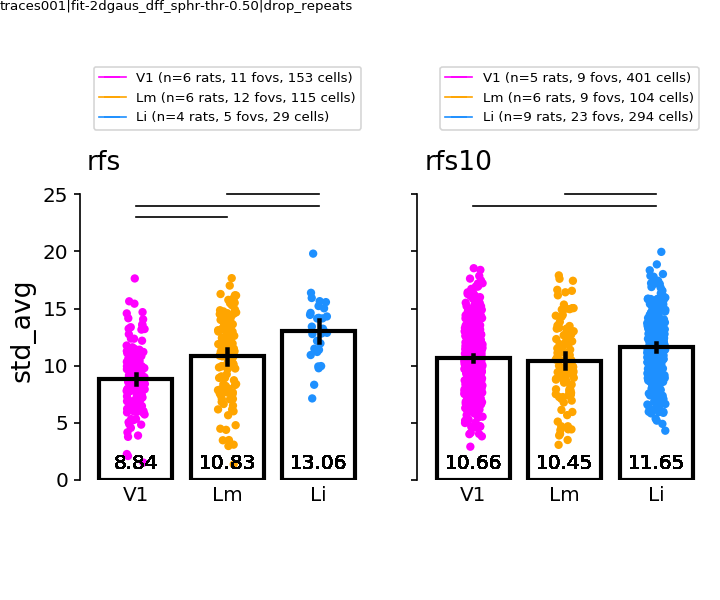

********* [rfs|mean std_avg] *********
[('V1', 'Lm')] p=0.000 (fdr_bh), reject H0=True
[('V1', 'Li')] p=0.000 (fdr_bh), reject H0=True
[('Lm', 'Li')] p=0.001 (fdr_bh), reject H0=True
********* [rfs10|mean std_avg] *********
[('V1', 'Lm')] p=0.331 (fdr_bh), reject H0=False
[('V1', 'Li')] p=0.000 (fdr_bh), reject H0=True
[('Lm', 'Li')] p=0.002 (fdr_bh), reject H0=True
('/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff_sphr/general-stats', 'all_filter-None__std_avg_RFvRF10_mean-all-cells_multicomp-fdr_bh__bar')


In [15]:
curr_metric = 'std_avg'
fov_means = False
plot_bar = True

multi_comp_test = 'fdr_bh' #'holm'
mean_metric = 'mean' # median
groupby = 'datakey' if fov_means else None
bar_str = 'bar' if plot_bar else ''
plot_str = '%s-by-%s' % (mean_metric, groupby) if fov_means else '%s-all-cells' % (mean_metric)
# ------------------------------------------------------------------------

fig, axn = pl.subplots(1, 2, figsize=(6,5), dpi=dpi, sharex=True, sharey=True)
fig.patch.set_alpha(0)

for ai, (ax, (experiment, expdf)) in enumerate(zip(axn.flat, r_df.groupby(['experiment']))):
    ax.patch.set_alpha(0)
        
    # Average RF sizes for each FOV
    grped = expdf.groupby(['visual_area', groupby]) if groupby is not None else expdf.groupby(['visual_area'])
    mean_sizes = grped.median().reset_index() if mean_metric=='median' else grped.mean().reset_index()
    # Plot means
    if plot_bar:
        sns.barplot(x="visual_area", y=curr_metric, data=expdf, 
                    ax=ax, order=visual_areas, ci=95,
                    errcolor="k", edgecolor=('k', 'k', 'k'), 
                    facecolor=(1,1,1,0), linewidth=2.5)
    else:
        sns.pointplot(x="visual_area", y=curr_metric, data=expdf, 
                        ax=ax, order=visual_areas, ci=95,
                        markers='_', join=False, capsize=0., dodge=True,
                        scale=3, color='k')
    # Plot points
    plotdf = mean_sizes if fov_means else expdf
    point_size = 10 if fov_means else 5
    sns.stripplot(x='visual_area', y=curr_metric, data=plotdf, 
                  zorder=-1, ax=ax, order=visual_areas, palette=area_colors,
                  s=point_size, color=(1,1,1,0), dodge=True, #facecolor=(1,1,1,0),
                  marker='o',linewidth=1, edgecolor='none')
    if ai>0:
        ax.set_ylabel('');
    ax.set_title(experiment, loc='left', fontsize=16)
    
    # Get counts of samples for legend
    legend_elements = aggr.get_counts_for_legend(expdf, area_colors=area_colors, markersize=10, marker='_')
    ax.legend(handles=legend_elements, bbox_to_anchor=(1,1.4), fontsize=8)
    ax.set_xlabel(''); ax.tick_params(axis='x', size=0);
    
    # Annotate w stats
    print("********* [%s|%s %s] *********" % (experiment, mean_metric, curr_metric))
    y_loc = 16 if fov_means else 23
    statresults = aggr.do_mannwhitney(plotdf, metric=curr_metric, multi_comp_test=multi_comp_test)
    aggr.annotate_stats_areas(statresults, ax, y_loc=y_loc, offset=1)

    plotdf.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=12, fontcolor='k')

ylim = 0 if fov_means else 0
ax.set_ylim([ylim, ax.get_ylim()[-1]])
pl.subplots_adjust(top=0.7, bottom=0.2, left=0.12, right=0.98)
sns.despine(offset=4, trim=True, bottom=True)

label_figure(fig, data_id)
figname = '%s__%s_RFvRF10_%s_multicomp-%s__%s' % (prefix, curr_metric, plot_str, multi_comp_test, bar_str)
dst_dir = basedir if 'None' in filter_str else genstats_dir
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)


Theta

# Distribution of thetas
#### 0 degrees is horizontal, where M>m | 90 degrees, spans more along vertical axis


<IPython.core.display.Javascript object>


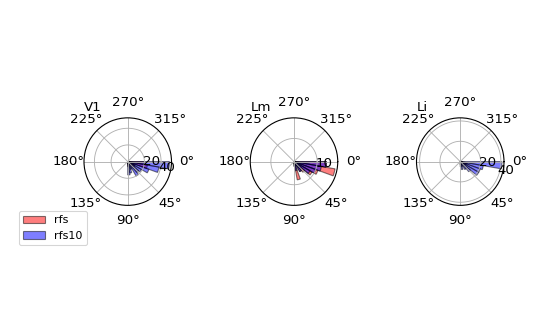

In [16]:
theta_metric = 'theta_Mm_c' # theta

bin_size = 20
colors=['r', 'b']
fig, axn = pl.subplots(1,3, subplot_kw=dict(projection='polar'), figsize=(7,4))
for ax, (visual_area, vdf) in zip(axn.flat[::-1], r_df.groupby(['visual_area'])):
    # ax.scatter()
    ax.set_title(visual_area, loc='left')
    for col, (experiment, g) in zip(colors, vdf.groupby(['experiment'])):
        thetas = g[theta_metric].values
        degrees = np.rad2deg(thetas)
        
        bin_size=10
        a , b=np.histogram(degrees, bins=np.arange(0, 360+bin_size, bin_size))
        centers = np.deg2rad(np.ediff1d(b)//2 + b[:-1])
        ax.bar(centers, a, width=np.deg2rad(bin_size), bottom=0.0, 
               color=col, edgecolor='none', alpha=0.5, label=experiment)
        
        ax.set_theta_zero_location("E")
        ax.set_theta_direction(-1)
ax.legend(bbox_to_anchor=(0.1, 0))

pl.subplots_adjust(left=0.15, wspace=0.9, hspace=0.5)

# Anisotropy (rfs v rfs10)

#### Get x + y components of vector spanned by ellipse (major)

In [17]:
#params=['r2', 'sigma_x', 'sigma_y', 'theta', 'x0', 'y0', 'datakey', 'cell', 'experiment', 'avg_size', 'fx', 'fy']

95
185


<IPython.core.display.Javascript object>


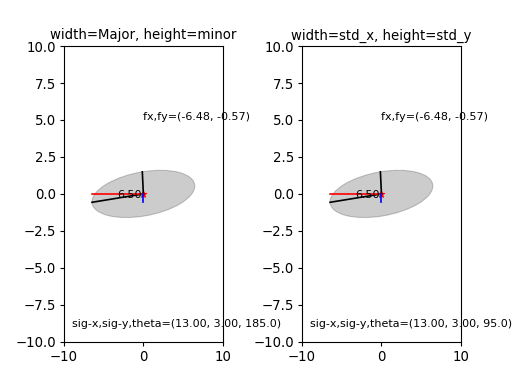

In [141]:
# 0 degrees is horizontal, where M>m
# 90 degrees, spans more along vertical axis

# If width < height (i.e., std_x < std_y), then 0deg=vertical, and 90deg=horizontal

std_x = 3 #12
std_y = 13 #12 #4
theta = 95 #357.7 #np.rad2deg(6.243)
print(theta)
# if std_x < std_y:
#     if (theta < 0):
#         angle = -1*(((360-theta) + 90) % 90)
#     elif (90 <= theta < 180) or (270 <= theta <360):
#         angle = (( (theta) % 90) + 90 + (180 if theta >=270 else 0)) % 360
#     else:
#         angle = (((theta + 90) % 90) + 180) % 360
# else:
#     angle = theta

if std_x < std_y:
#     if (theta < 0):
#         angle = -1*(((360-theta) + 90) % 90)
#     if (270 <= theta < 360):
#         #angle = (( (theta) % 90)) % 360
#         angle = (theta + 90) % 360
    if (90 <= theta < 360):
        angle = (theta + 90) % 360     
#     elif (90 <= theta < 180):
#         #angle = ( (theta % 90) + 180) % 360
#         angle = (theta + 90) % 360
    else:
        angle = (((theta) % 90) + 90) % 360
else:
    angle = theta
    
print(angle)
M = max([std_x, std_y])
m = min([std_x, std_y])

x0, y0 = (0, 0)
fig, axn = pl.subplots(1, 2) #pl.figure()
ax=axn[0]
ax.plot(x0, y0, 'r*')
el = Ellipse((x0, y0), width=M, height=m, angle=angle, alpha=0.2, color='k')
ax.add_artist(el)
ax.set_xlim([-10, 10]); ax.set_ylim([-10, 10]);

F = M/2.
xe = F * np.cos(np.deg2rad(angle))
ye = F * np.sin(np.deg2rad(angle))
ax.plot([x0, xe], [y0, ye], 'k')
ax.text(xe/2., ye/2., '%.2f' % F)

xe2 = (m/2.) * np.sin(np.deg2rad(180-angle))
ye2 = (m/2.) * np.cos(np.deg2rad(180-angle))
ax.plot([x0, xe2], [y0, ye2], 'k')

fx = round(F * np.cos(np.deg2rad(angle)), 2)
fy = round(F * np.sin(np.deg2rad(angle)), 2)

ax.text(0, 5, 'fx,fy=(%.2f, %.2f)' % (fx, fy))
ax.text(-9, -9, 'sig-x,sig-y,theta=(%.2f, %.2f, %.1f)' % (M, m, angle))
ax.plot([x0, fx], [y0, y0], 'r')
ax.plot([x0, x0], [y0, fy], 'b')
ax.set_title('width=Major, height=minor')


ax=axn[1]
ax.plot(x0, y0, 'r*')
el = Ellipse((x0, y0), width=std_x, height=std_y, angle=theta, alpha=0.2, color='k')
ax.add_artist(el)
ax.set_xlim([-10, 10]); ax.set_ylim([-10, 10]);

# F = M/2.
# xe = (std_x/2.) * np.cos(np.deg2rad(theta)) if std_x>std_y else (std_y/2.) * np.sin(np.deg2rad(theta))
# ye = (std_x/2.) * np.sin(np.deg2rad(theta)) if std_x>std_y else (std_x/2.) * np.cos(np.deg2rad(theta))
# ax.plot([x0, xe], [y0, ye], 'k')
# ax.text(xe/2., ye/2., '%.2f' % F)
F = M/2.
# xe = (std_x/2.) * np.cos(np.deg2rad(theta)) if std_x>std_y else (std_y/2.) * np.cos(np.deg2rad(theta))
# ye = (std_x/2.) * np.sin(np.deg2rad(theta)) if std_x>std_y else (std_y/2.) * np.cos(np.deg2rad(theta))
# ax.plot([x0, xe], [y0, ye], 'k')
# ax.text(xe/2., ye/2., '%.2f' % F)
xe = F * np.cos(np.deg2rad(theta)) if std_x>std_y else -F * np.sin(np.deg2rad(theta))
ye = F * np.sin(np.deg2rad(theta)) if std_x>std_y else F * np.cos(np.deg2rad(theta))
ax.plot([x0, xe], [y0, ye], 'k')
ax.text(xe/2., ye/2., '%.2f' % F)

xe2 = (m/2.) * np.sin(np.deg2rad(theta)) if std_x>std_y else -(m/2.) * np.cos(np.deg2rad(180-theta))
ye2 = (m/2.) * np.cos(np.deg2rad(theta)) if std_x>std_y else (m/2.) * np.sin(np.deg2rad(180-theta))
ax.plot([x0, xe2], [y0, ye2], 'k')



fx = round(xe, 2)
fy = round(ye, 2)

ax.text(0, 5, 'fx,fy=(%.2f, %.2f)' % (fx, fy))
ax.text(-9, -9, 'sig-x,sig-y,theta=(%.2f, %.2f, %.1f)' % (M, m, theta))
ax.plot([x0, fx], [y0, y0], 'r')
ax.plot([x0, x0], [y0, fy], 'b')

ax.set_title('width=std_x, height=std_y')

pl.subplots_adjust(wspace=0.5)

# Create anisotropy index 

In [17]:
r_df['theta'].min(), r_df['theta'].max()    

(0.0047270667549296225, 6.2705060413283187)

In [18]:
rdf = r_df[r_df['visual_area']=='V1'].copy()

subset = rdf[['datakey', 'cell', 'x0', 'y0', 'theta', 'std_x', 'std_y', 'anisotropy', 'theta_c', 'theta_Mm_c']].sort_values(by='anisotropy', ascending=False)
subset['deg'] = (np.rad2deg(subset['theta_Mm_c']) + 360.) % 360.
subset['sign'] = abs(np.sin(subset['theta_Mm_c'])) # vertical=90d, (1 or -1); horizontal=0deg (0)
subset['AI_c'] = subset['sign'] + subset['anisotropy']

subset.iloc[0:10]

datakey   cell         x0         y0     theta      std_x  \
1082  20191106_JC120_fov3   82.0  28.806910  12.361794  5.906983  17.519540   
1048  20191006_JC110_fov1  273.0  24.673719  12.720739  6.212093   2.431599   
885   20190616_JC097_fov1   97.0  33.473518  -9.643153  0.027990  14.523410   
1073  20191106_JC120_fov3   45.0  45.021253   8.489552  0.010066   2.999438   
730   20190615_JC097_fov1  166.0  34.159263  -0.460971  6.208914  13.324846   
915   20190616_JC097_fov1  415.0  30.124335  -7.992669  0.109617  17.143640   
1091  20191106_JC120_fov3  209.0  34.406280  11.326061  5.857258  10.678049   
828   20190615_JC097_fov2  258.0  35.975139 -16.192117  6.009308  20.391914   
1032  20191006_JC110_fov1  114.0  24.815756   8.328544  4.705066  10.790786   
903   20190616_JC097_fov1  290.0  33.777601 -17.178780  1.266229   3.883204   

          std_y  anisotropy   theta_c  theta_Mm_c         deg      sign  \
1082   2.440498    0.755462 -0.376202   -0.376202  338.445194  0.367391   
1048  16.234807    0.739468 -0.071092    1.499704   85.926737  0.997474   
885    2.426168    0.713719  0.027990    0.027990    1.603708  0.027986   
1073  16.103525    0.685971  0.010066   -1.560731  270.576722  0.999949   
730    2.634160    0.669884 -0.074271   -0.074271  355.744562  0.074203   
915    3.945974    0.625790  0.109617    0.109617    6.280607  0.109398   
1091   2.471070    0.624147 -0.425928   -0.425928  335.596144  0.413166   
828    5.186854    0.594441 -0.273878   -0.273878  344.307960  0.270467   
1032   2.788117    0.589346  1.563474    1.563474   89.580439  0.999973   
903   14.590874    0.579605  1.266229   -0.304568  342.549562  0.299881   

          AI_c  
1082  1.122853  
1048  1.736942  
885   0.741706  
1073  1.685921  
730   0.744087  
915   0.735188  
1091  1.037312  
828   0.864907  
1032  1.589319  
903   0.879486

In [19]:
subset['theta_c'].min(), subset['theta_c'].max()

(-1.5634030740878242, 1.5652833190604247)

<IPython.core.display.Javascript object>


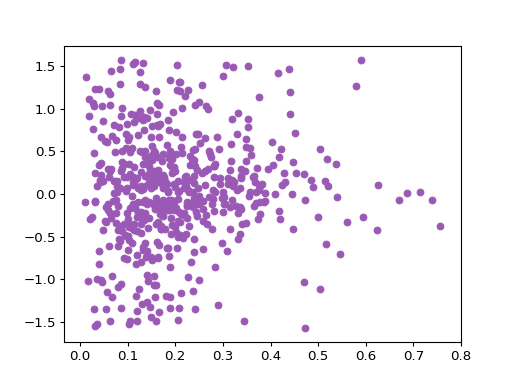

In [20]:
fig, ax =pl.subplots()
ax.scatter(subset['anisotropy'], subset['theta_c'])


In [63]:
subset.columns

Index([u'r2', u'fwhm_x', u'fwhm_y', u'theta', u'x0', u'y0', u'animalid',
       u'cell', u'datakey', u'experiment', u'fovnum', u'session',
       u'visual_area', u'std_x', u'std_y', u'fwhm_avg', u'std_avg', u'area',
       u'fx', u'fy', u'ratio_xy', u'theta_c', u'theta_Mm_deg', u'major_axis',
       u'minor_axis', u'anisotropy', u'theta_Mm_c', u'aniso_index',
       u'datakey_ix'],
      dtype='object')

<IPython.core.display.Javascript object>


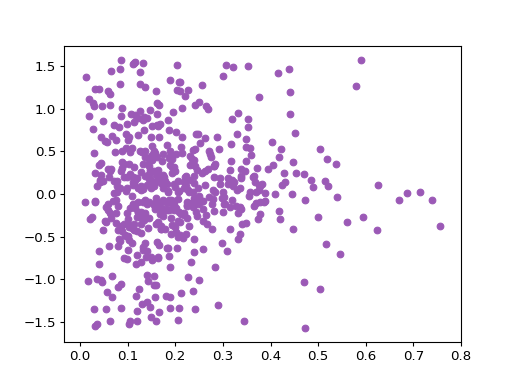

In [21]:
subset = r_df[r_df['visual_area']=='V1'].copy()
fig, ax =pl.subplots()
ax.scatter(subset['anisotropy'], subset['theta_c'])


# Create mixed df

In [22]:
r_list=[]
for (visual_area, datakey), g in r_df.groupby(['visual_area', 'datakey']):
    if ('rfs' in g['experiment'].values and 'rfs10' in g['experiment'].values):
        print('%s: %s' % (visual_area, datakey))
        if visual_area=='Li':
            r_list.append(g[g['experiment']=='rfs10'])
        else:
            r_list.append(g[g['experiment']=='rfs'])
    else:
        r_list.append(g)
mixdf = pd.concat(r_list, axis=0).reset_index(drop=True)


Li: 20190522_JC089_fov1
Li: 20190602_JC091_fov1
Li: 20191007_JC091_fov1
Li: 20191017_JC113_fov1
Lm: 20190618_JC097_fov1
V1: 20190613_JC097_fov1
V1: 20190616_JC097_fov1
V1: 20190622_JC085_fov1
V1: 20191006_JC110_fov1


In [23]:
mixdf.columns

Index([u'r2', u'fwhm_x', u'fwhm_y', u'theta', u'x0', u'y0', u'animalid',
       u'cell', u'datakey', u'experiment', u'fovnum', u'session',
       u'visual_area', u'std_x', u'std_y', u'fwhm_avg', u'std_avg', u'area',
       u'fx', u'fy', u'ratio_xy', u'theta_c', u'theta_Mm_deg', u'major_axis',
       u'minor_axis', u'anisotropy', u'theta_Mm_c', u'aniso_index',
       u'datakey_ix'],
      dtype='object')

# General Stats

In [24]:
few_cells = [dk for (dk, rfname), g in r_df.groupby(['datakey', 'experiment']) if len(g)<10]


In [25]:
r_df[(r_df['visual_area']=='V1') & (r_df['experiment']=='rfs10') & (r_df['anisotropy']>0.5)]

r2     fwhm_x     fwhm_y     theta         x0         y0 animalid  \
658   0.545806  37.925693  12.092548  5.703941  28.093077   5.239064    JC097   
730   0.681339  31.313388   6.190276  6.208914  34.159263  -0.460971    JC097   
736   0.572307  30.316586   8.528287  5.955291  33.868864   0.219263    JC097   
764   0.545767  32.809536  10.931811  6.014541  31.909448  -2.720166    JC097   
767   0.510247  14.919797  45.205158  5.169953  38.335981  -1.673765    JC097   
810   0.639795  41.335167  13.070206  0.405282  30.449855 -10.076165    JC097   
828   0.678521  47.920997  12.189106  6.009308  35.975139 -16.192117    JC097   
885   0.503069  34.130012   5.701496  0.027990  33.473518  -9.643153    JC097   
903   0.596040   9.125529  34.288553  1.266229  33.777601 -17.178780    JC097   
915   0.627680  40.287554   9.273039  0.109617  30.124335  -7.992669    JC097   
980   0.523148   5.614518  17.826130  0.097861  24.317623   0.108872    JC110   
985   0.622463  16.746179   5.378883  0.152176  21.005845  -0.258348    JC110   
1032  0.631888  25.358346   6.552074  4.705066  24.815756   8.328544    JC110   
1048  0.502804   5.714258  38.151797  6.212093  24.673719  12.720739    JC110   
1070  0.504896  24.757317   7.434188  0.350301  42.275799   3.200663    JC117   
1073  0.563856   7.048679  37.843284  0.010066  45.021253   8.489552    JC120   
1079  0.632287   6.510906  21.776666  6.249625  45.145474  16.718539    JC120   
1082  0.507763  41.170919   5.735170  5.906983  28.806910  12.361794    JC120   
1085  0.505269  41.386284  13.663222  0.528745  35.767873  -6.275596    JC120   
1089  0.627223  11.145973  38.010406  2.442889  15.507889  14.919085    JC120   
1091  0.691456  25.093415   5.807015  5.857258  34.406280  11.326061    JC120   

       cell              datakey experiment     ...             fy  ratio_xy  \
658     5.0  20190613_JC097_fov1      rfs10     ...       8.834126  3.136286   
730   166.0  20190615_JC097_fov1      rfs10     ...       0.988745  5.058480   
736   184.0  20190615_JC097_fov1      rfs10     ...       4.154671  3.554827   
764    17.0  20190615_JC097_fov2      rfs10     ...       3.705723  3.001290   
767    30.0  20190615_JC097_fov2      rfs10     ...      17.257433  0.330046   
810   164.0  20190615_JC097_fov2      rfs10     ...       6.935133  3.162549   
828   258.0  20190615_JC097_fov2      rfs10     ...       5.515334  3.931461   
885    97.0  20190616_JC097_fov1      rfs10     ...       0.406457  5.986151   
903   290.0  20190616_JC097_fov1      rfs10     ...      13.919354  0.266139   
915   415.0  20190616_JC097_fov1      rfs10     ...       1.875478  4.344590   
980   161.0  20191004_JC110_fov2      rfs10     ...       0.741150  0.314960   
985   218.0  20191004_JC110_fov2      rfs10     ...       1.080231  3.113319   
1032  114.0  20191006_JC110_fov1      rfs10     ...      10.790496  3.870278   
1048  273.0  20191006_JC110_fov1      rfs10     ...       1.153191  0.149777   
1070  183.0  20191111_JC117_fov1      rfs10     ...       3.615415  3.330198   
1073   45.0  20191106_JC120_fov3      rfs10     ...       0.162091  0.186260   
1079   61.0  20191106_JC120_fov3      rfs10     ...       0.310935  0.298985   
1082   82.0  20191106_JC120_fov3      rfs10     ...       6.436522  7.178674   
1085  112.0  20191106_JC120_fov3      rfs10     ...       8.883962  3.029028   
1089  169.0  20191106_JC120_fov3      rfs10     ...      10.403942  0.293235   
1091  209.0  20191106_JC120_fov3      rfs10     ...       4.411804  4.321224   

       theta_c  theta_Mm_deg  major_axis  minor_axis  anisotropy  theta_Mm_c  \
658  -0.579244    326.811769   16.138593    5.145765    0.516474   -0.579244   
730  -0.074271    355.744562   13.324846    2.634160    0.669884   -0.074271   
736  -0.327895    341.213015   12.900675    3.629058    0.560905   -0.327895   
764  -0.268644    344.607834   13.961505    4.651835    0.500161   -0.268644   
767  -1.113233     26.216471   19.236237    6.348850    0.503707    

In [27]:
filter_by

## Anisotropy v Orientation

<IPython.core.display.Javascript object>


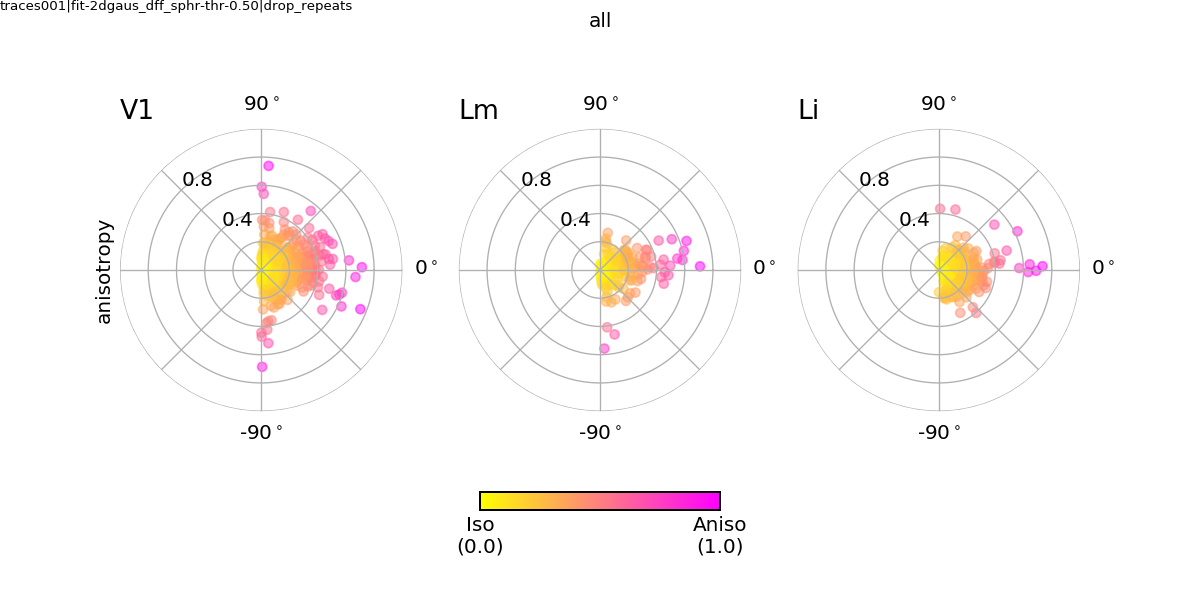

In [33]:
metric = 'anisotropy' #'ratio_xy'
cmap='spring_r'
# ---------------------------------------------------
rfname = 'all'

if rfname=='mixed':
    expdf = mixdf.copy()
elif rfname == 'all':
    if filter_by is None:
        expdf = r_df.copy()
    else:
        expdf = alldf.copy()
else:
    expdf = r_df[(r_df['experiment']==rfname)].copy()
# ---------------------------------------------------

expdf = expdf[~expdf['datakey'].isin(few_cells)]
expdf = expdf[expdf['r2']>0.5]

norm = mpl.colors.Normalize(vmin=0, vmax=1)
iso_cmap = cm.ScalarMappable(norm=norm, cmap=cmap)

fig, axn = pl.subplots(1,3, subplot_kw=dict(projection='polar'), figsize=(10,5), dpi=dpi)
for ai, (visual_area, g) in enumerate(expdf.groupby(['visual_area'])):
    ax = axn[2-ai]
    ax = rfutils.anisotropy_polarplot(g, metric=metric, cmap=cmap, ax=ax)
    ax.set_ylim([0, 1])
    ax.set_title(visual_area, fontsize=16, loc='left')
    
    ax.set_xticklabels(['0$^\circ$', '', '90$^\circ$', '', '', '', '-90$^\circ$', ''])
    ax.set_rlabel_position(135) #315)
    ax.set_xlabel('')
    ax.set_yticklabels(['', 0.4, '', 0.8])
    if ai==2:
        ax.set_ylabel(metric, fontsize=12)
    else:
        ax.set_ylabel('')
    # Grid lines and such
    ax.spines['polar'].set_visible(False)
    
pl.suptitle(rfname)
putils.label_figure(fig, data_id)

pl.savefig(os.path.join(dst_dir, '%s__anisotropy_polarplots.svg' % prefix))

<IPython.core.display.Javascript object>


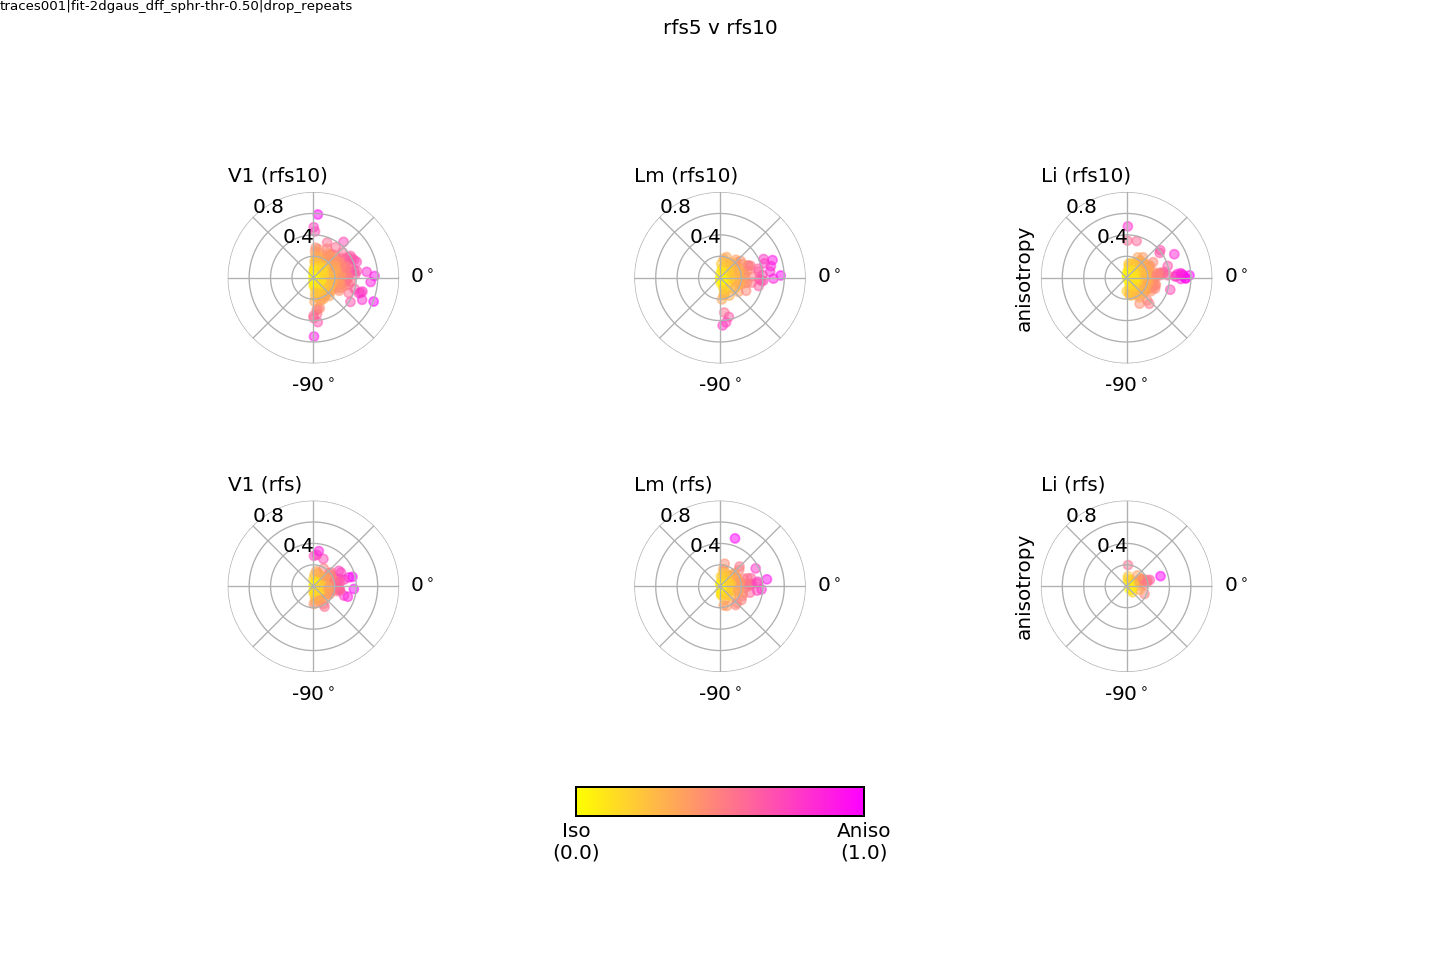

In [36]:
metric = 'anisotropy' #'ratio_xy'
cmap='spring_r'
# ---------------------------------------------------
rfname = 'all'

if rfname=='mixed':
    expdf = mixdf.copy()
elif rfname == 'all':
    if filter_by is None:
        expdf = r_df.copy()
    else:
        expdf = alldf.copy()
else:
    expdf = r_df[(r_df['experiment']==rfname)].copy()
# ---------------------------------------------------

norm = mpl.colors.Normalize(vmin=0, vmax=1)
iso_cmap = cm.ScalarMappable(norm=norm, cmap=cmap)

fig, axn = pl.subplots(2,3, subplot_kw=dict(projection='polar'), figsize=(12,8), dpi=dpi)
for ai, ((rfname, visual_area), g) in enumerate(r_df.groupby(['experiment', 'visual_area'])):
    ax = axn.flat[5-ai]
    ax = rfutils.anisotropy_polarplot(g, metric=metric, cmap=cmap, ax=ax)
    ax.set_ylim([0, 1])
    ax.set_title('%s (%s)' % (visual_area, rfname), fontsize=12, loc='left')
    
    #ax.set_xticklabels(['0$^\circ$', '', '90$^\circ$', '', '', '', '-90$^\circ$', ''])
    ax.set_xticklabels(['0$^\circ$', '', '', '', '', '', '-90$^\circ$', ''])
    ax.set_rlabel_position(135) #315)
    ax.set_xlabel('')
    ax.set_yticklabels(['', 0.4, '', 0.8])
    if ai==0 or ai==3:
        ax.set_ylabel(metric, fontsize=12)
    else:
        ax.set_ylabel('')
    # Grid lines and such
    ax.spines['polar'].set_visible(False)
    
pl.suptitle('rfs5 v rfs10')

pl.subplots_adjust(wspace=0.2, hspace=0.8)
putils.label_figure(fig, data_id)

pl.savefig(os.path.join(dst_dir, '%s__anisotropy_polarplots_split-rfs5-rfs10.svg' % prefix))

In [37]:
dst_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff_sphr/general-stats'

In [39]:
bothdf = pd.concat([g for (visual_area, datakey), g in expdf.groupby(['visual_area', 'datakey']) 
                     if 'rfs' in g['experiment'].values and 'rfs10' in g['experiment'].values], axis=0)
bothdf.shape


(326, 29)

In [40]:
bothdf[['visual_area', 'datakey']].drop_duplicates()['visual_area'].value_counts()

Li    4
V1    4
Lm    1
Name: visual_area, dtype: int64

<IPython.core.display.Javascript object>


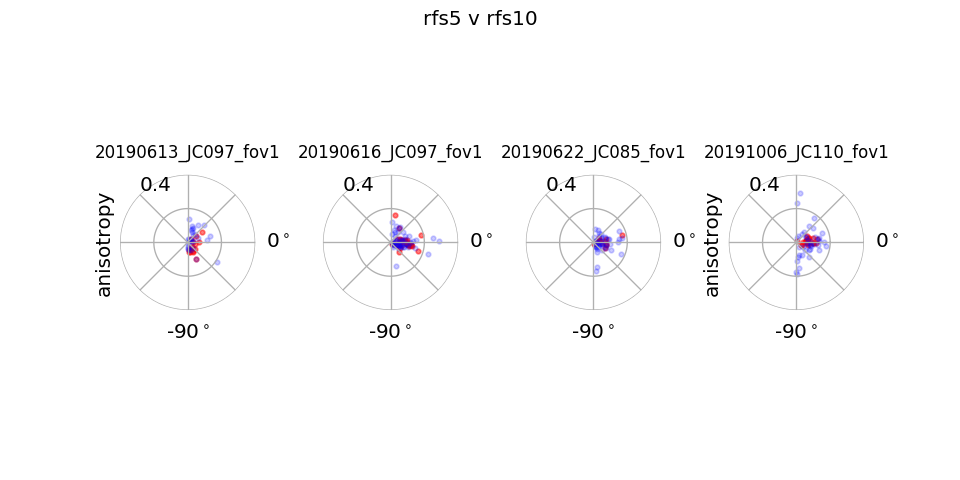

In [41]:
plotdf = bothdf[bothdf['visual_area']=='V1']

fig, axn = pl.subplots(1, 4, subplot_kw=dict(projection='polar'), figsize=(8,4), dpi=dpi)
for ai, (datakey, ddf) in enumerate(plotdf.groupby([ 'datakey'])):
    ax = axn.flat[ai]
    g1 = ddf[ddf['experiment']=='rfs']
    thetas = g1['theta_Mm_c'].values #% np.pi
    radii = g1['anisotropy'].values
    ax.scatter(thetas, radii, s=30, c='r', alpha=0.5, marker='.')
    #ax = anisotropy_polarplot(g1, metric=metric, cmap='Reds', ax=ax, alpha=0.2, )
    
    g2 = ddf[ddf['experiment']=='rfs10']    
    thetas = g2['theta_Mm_c'].values #% np.pi
    radii = g2['anisotropy'].values
    ax.scatter(thetas, radii, s=30, c='b', alpha=0.2, marker='.')
    #ax = anisotropy_polarplot(g2, metric=metric, cmap='Blues', ax=ax, alpha=0.2)
    ax.set_ylim([0, 1])
    ax.set_title(datakey, fontsize=10)
    
    #ax.set_xticklabels(['0$^\circ$', '', '90$^\circ$', '', '', '', '-90$^\circ$', ''])
    ax.set_xticklabels(['0$^\circ$', '', '', '', '', '', '-90$^\circ$', ''])
    ax.set_rlabel_position(135) #315)
    ax.set_xlabel('')
    ax.set_yticklabels(['', 0.4, '', 0.8])
    if ai==0 or ai==3:
        ax.set_ylabel(metric, fontsize=12)
    else:
        ax.set_ylabel('')
    # Grid lines and such
    ax.spines['polar'].set_visible(False)
    
pl.suptitle('rfs5 v rfs10')

pl.subplots_adjust(wspace=0.5, hspace=0.8)

## spatial distn of anisotropy

<IPython.core.display.Javascript object>


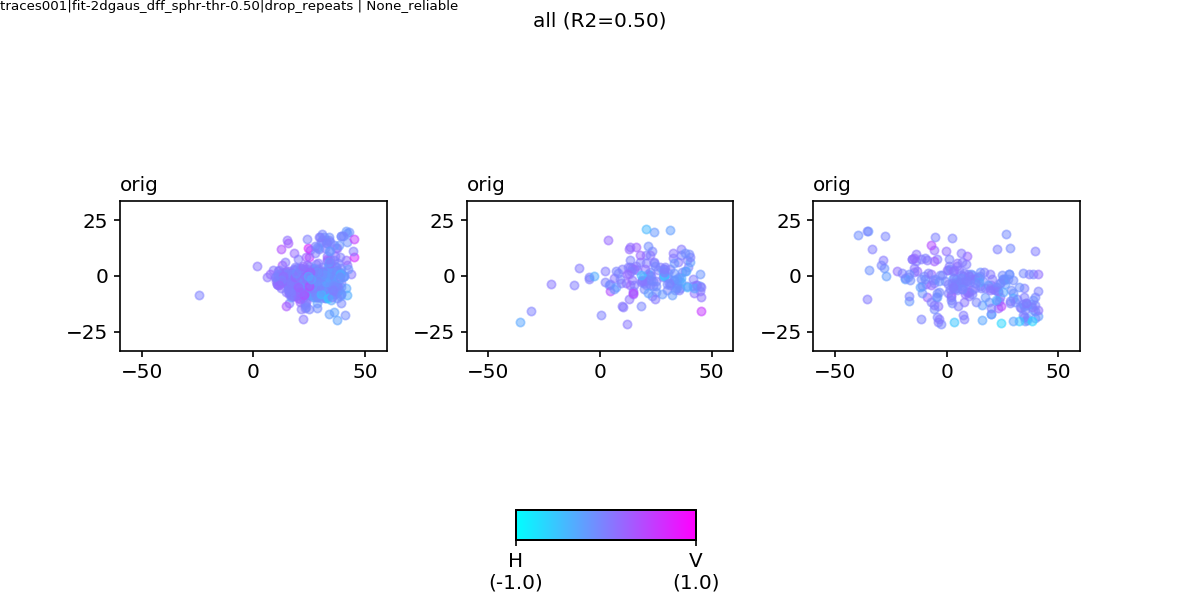

In [45]:
# ---------------------------------------------------
hue_param = 'aniso_index'
shape_str = 'centroid'
axis_lw=1
axis_alpha=1
centroid_alpha=0.5
ellipse_scale = 2.35

# ---------------------------------------------------
rfname = 'all'

if rfname=='mixed':
    expdf = mixdf.copy()
elif rfname == 'all':
    if filter_by is None:
        expdf = r_df.copy()
    else:
        expdf = alldf.copy()
else:
    expdf = r_df[(r_df['experiment']==rfname)].copy()
# ---------------------------------------------------

expdf = expdf[~expdf['datakey'].isin(few_cells)]
expdf = expdf[expdf['r2']>0.5]

norm = mpl.colors.Normalize(vmin=0, vmax=1)
iso_cmap = cm.ScalarMappable(norm=norm, cmap=cmap)

fig, axn = pl.subplots(1,3,figsize=(10,5), dpi=dpi)
for ai, (visual_area, g) in enumerate(expdf.groupby(['visual_area'])):
    ax = axn[2-ai]
    ax = rfutils.draw_rf_on_screen(g.dropna(), hue_param=hue_param, ax=ax,
                           shape_str=shape_str, ellipse_scale=ellipse_scale, 
                           axis_lw=axis_lw, axis_alpha=axis_alpha,
                           centroid_alpha=centroid_alpha)
    ax.set_title('orig', loc='left')
    #ax.set_ylim([-20, 20])
    #ax.set_xlim([0, 50

pl.subplots_adjust(left=0.1, right=0.9, wspace=0.3, bottom=0.2)
pl.suptitle('%s (R2=%.2f)' % (rfname, 0.5))

putils.label_figure(fig, '%s | %s' % (data_id, filter_str))
#ax.set_ylim([-20, 20])
#ax.set_xlim([0, 50])


pl.savefig(os.path.join(dst_dir, '%s__spatial_distn_%s.svg' % (prefix, shape_str)))

In [36]:
alldf.shape, mixdf.shape, r_df.shape

((2874, 28), (1391, 28), (1881, 28))

In [82]:
r_df.shape

(1881, 28)

In [31]:
alldf[['visual_area', 'datakey', 'experiment', 'cell']].drop_duplicates().groupby(['visual_area', 'experiment']).count()

datakey  cell
visual_area experiment               
Li          rfs              29    29
            rfs10           294   294
Lm          rfs             115   115
            rfs10           104   104
V1          rfs             153   153
            rfs10           401   401

In [32]:
r_df[['visual_area', 'datakey', 'experiment', 'cell']].drop_duplicates().groupby(['visual_area', 'experiment']).count()

datakey  cell
visual_area experiment               
Li          rfs               9     9
            rfs10           178   178
Lm          rfs              39    39
            rfs10            78    78
V1          rfs             139   139
            rfs10           206   206

# Get screen info

In [46]:
screen = putils.get_screen_dims()
screenleft, screenright = [-screen['azimuth_deg']*0.5, screen['azimuth_deg']*0.5]
screenbottom, screentop = [-screen['altitude_deg']*0.5, screen['altitude_deg']*0.5]


## Position

<IPython.core.display.Javascript object>


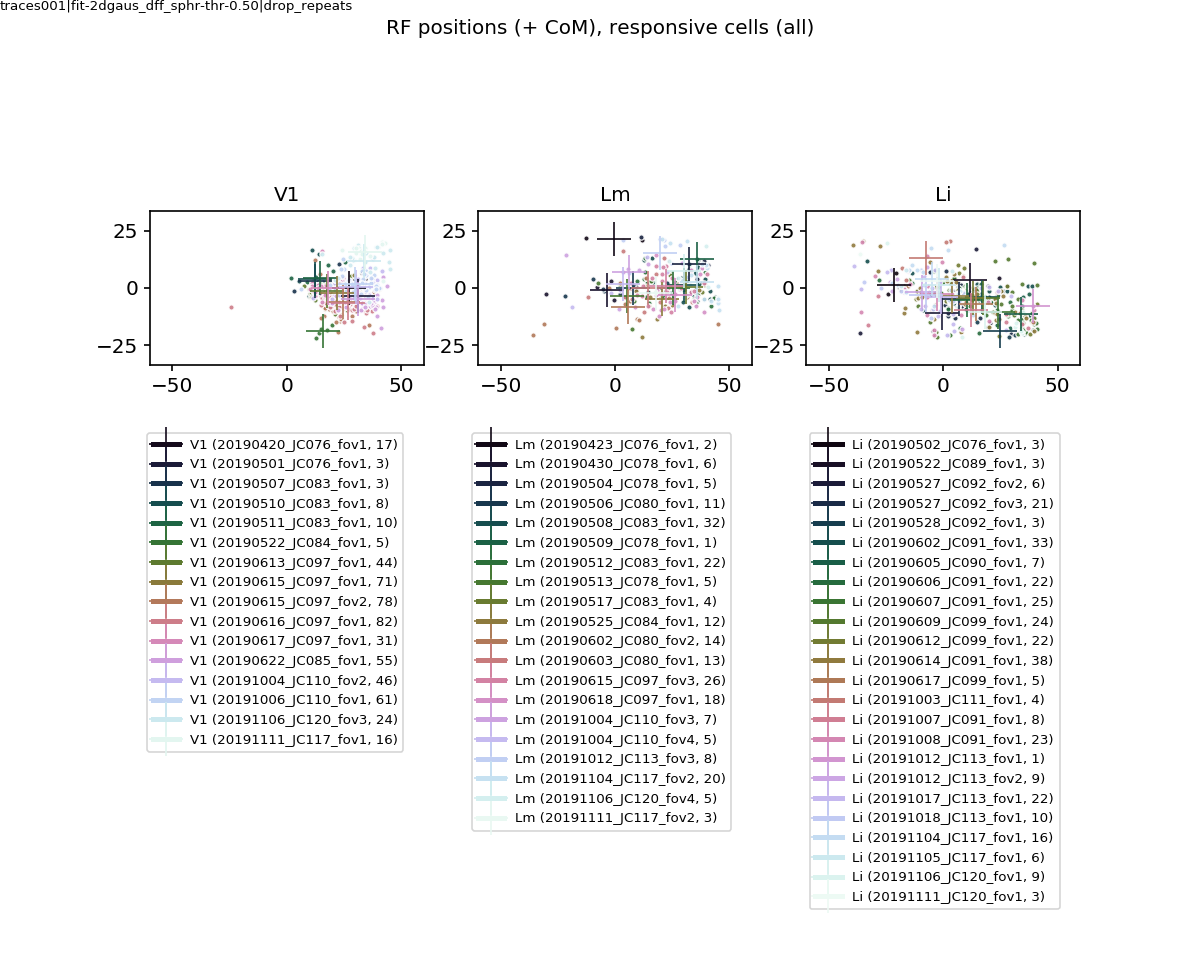

('/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff_sphr/general-stats', 'all_filter-None__CoM_label-fovs')


In [47]:
# ---------------------------------------------------
rfname = 'all'


if rfname=='mixed':
    expdf = mixdf.copy()
elif rfname == 'all':
    if filter_by is None:
        expdf = r_df.copy()
    else:
        expdf = alldf.copy()
else:
    expdf = r_df[(r_df['experiment']==rfname)].copy()
# ---------------------------------------------------

fig, axn = pl.subplots(1,3, figsize=(10,8), dpi=dpi)

for visual_area, v_df in expdf.groupby(['visual_area']):
    ai = visual_areas.index(visual_area)
    ax = axn[ai]
    dcolors = sns.color_palette('cubehelix', n_colors=len(v_df['datakey'].unique()))
    for di, (datakey, d_df) in enumerate(v_df.groupby(['datakey'])):
        sns.scatterplot('x0', 'y0', data=d_df, ax=ax, color=dcolors[di],
                       s=10, marker='o', alpha=0.9, edgecolor='w') #, edgecolor='k') #area_colors[visual_area])

        x = d_df['x0'].values
        y=d_df['y0'].values
        
        ncells_t = d_df.shape[0]
        m=np.ones(d_df['x0'].shape)
        cgx = np.sum(x*m)/np.sum(m)
        cgy = np.sum(y*m)/np.sum(m)
        #print('The center of mass: (%.2f, %.2f)' % (cgx, cgy))
        ax.plot(cgx, cgy, marker='+', markersize=20, color=dcolors[di], #area_colors[visual_area],
                label='%s (%s, %i)' % (visual_area, datakey, ncells_t), lw=3)
        
    ax.set_title(visual_area)
    ax.legend(bbox_to_anchor=(0.95, -0.4), fontsize=8) #1))

for ax in axn:
    ax.set_xlim([screenleft, screenright])
    ax.set_ylim([screenbottom, screentop])
    ax.set_aspect('equal')
    ax.set_ylabel('')
    ax.set_xlabel('')
    
pl.suptitle("RF positions (+ CoM), responsive cells (%s)" % rfname)
pl.subplots_adjust(top=0.9, bottom=0.5)
putils.label_figure(fig, data_id)

figname = '%s__CoM_label-fovs' % (prefix)
dst_dir = basedir if 'None' in filter_str else genstats_dir
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)


In [103]:
min_ai = -1
max_ai = 2.0


In [108]:
subset.shape

(1070, 14)

<IPython.core.display.Javascript object>


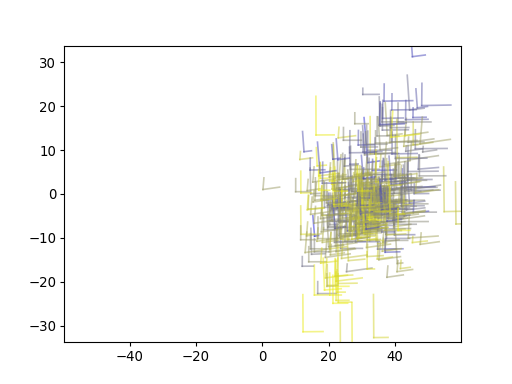

In [149]:
fig, ax = pl.subplots()
ax.set_xlim([screenleft, screenright]); ax.set_ylim([screenbottom, screentop]);

for i in subset.index.tolist()[0:500]:
    x0, y0, std_x, std_y, theta, aniso = subset[['x0', 'y0', 'std_x', 'std_y', 'theta', 'AI_c']].loc[i]
    
    norm_ai = (aniso - min_ai) / (max_ai - min_ai)
    ai_color = (1.-norm_ai, 1.-norm_ai, norm_ai)
    
    #ax.plot(x0, y0, marker='o', color=ai_color)
    el = Ellipse((x0, y0), width=std_x, height=std_y, angle=theta, alpha=0.0, color=ai_color)
    ax.add_artist(el)

    M = subset[['std_x', 'std_y']].loc[i].max()  
    m = subset[['std_x', 'std_y']].loc[i].min()  
    F = M/2.
    xe = F * np.cos(np.deg2rad(theta)) if std_x>std_y else -F * np.sin(np.deg2rad(theta))
    ye = F * np.sin(np.deg2rad(theta)) if std_x>std_y else F * np.cos(np.deg2rad(theta))
    ax.plot([x0, x0+xe], [y0, y0+ye], color=ai_color, alpha=0.5)
    
    xe2 = (m/2.) * np.sin(np.deg2rad(theta)) if std_x>std_y else -(m/2.) * np.cos(np.deg2rad(180-theta))
    ye2 = (m/2.) * np.cos(np.deg2rad(theta)) if std_x>std_y else (m/2.) * np.sin(np.deg2rad(180-theta))
    ax.plot([x0, x0+xe2], [y0, y0+ye2], color=ai_color, alpha=0.5)



<IPython.core.display.Javascript object>


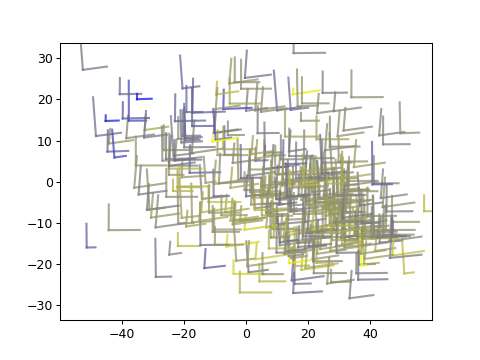

In [42]:
fig, ax = pl.subplots()
ax.set_xlim([screenleft, screenright]); ax.set_ylim([screenbottom, screentop]);

vdf=alldf[alldf['visual_area']=='Li'].copy()

min_ai = r_df['aniso_index'].min()
max_ai = r_df['aniso_index'].max()

for i in vdf.index.tolist()[0::2]:
    x0, y0, std_x, std_y, theta, aniso = vdf[['x0', 'y0', 'std_x', 'std_y', 'theta', 'aniso_index']].loc[i]
    
    norm_ai = (aniso - min_ai) / (max_ai - min_ai)
    ai_color = (1.-norm_ai, 1.-norm_ai, norm_ai)
    #print(norm_ai, aniso)
    #ax.plot(x0, y0, marker='o', color=ai_color)
    el = Ellipse((x0, y0), width=std_x, height=std_y, angle=theta, alpha=0.0, color=ai_color)
    ax.add_artist(el)

    M = vdf[['std_x', 'std_y']].loc[i].max()  
    m = vdf[['std_x', 'std_y']].loc[i].min()  
    F = M/2.
    xe = F * np.cos(np.deg2rad(theta)) if std_x>std_y else -F * np.sin(np.deg2rad(theta))
    ye = F * np.sin(np.deg2rad(theta)) if std_x>std_y else F * np.cos(np.deg2rad(theta))
    ax.plot([x0, x0+xe], [y0, y0+ye], color=ai_color, alpha=0.75, lw=2)
    
    xe2 = (m/2.) * np.sin(np.deg2rad(theta)) if std_x>std_y else -(m/2.) * np.cos(np.deg2rad(180-theta))
    ye2 = (m/2.) * np.cos(np.deg2rad(theta)) if std_x>std_y else (m/2.) * np.sin(np.deg2rad(180-theta))
    ax.plot([x0, x0+xe2], [y0, y0+ye2], color=ai_color, alpha=0.75, lw=2)


In [49]:
def assign_saturation(hue_param, saturation_param, min_v=0, max_v=1):
    norm_ai = (saturation_param - min_v) / (max_v - min_v)
    theta_rgb = scalar_cmap.to_rgba(abs(np.sin(hue_param)))
    theta_hsv = mcolors.rgb_to_hsv(theta_rgb[0:3])
    theta_hsv[1] = norm_ai
    theta_col = mcolors.hsv_to_rgb(theta_hsv)     
    return theta_col

<IPython.core.display.Javascript object>


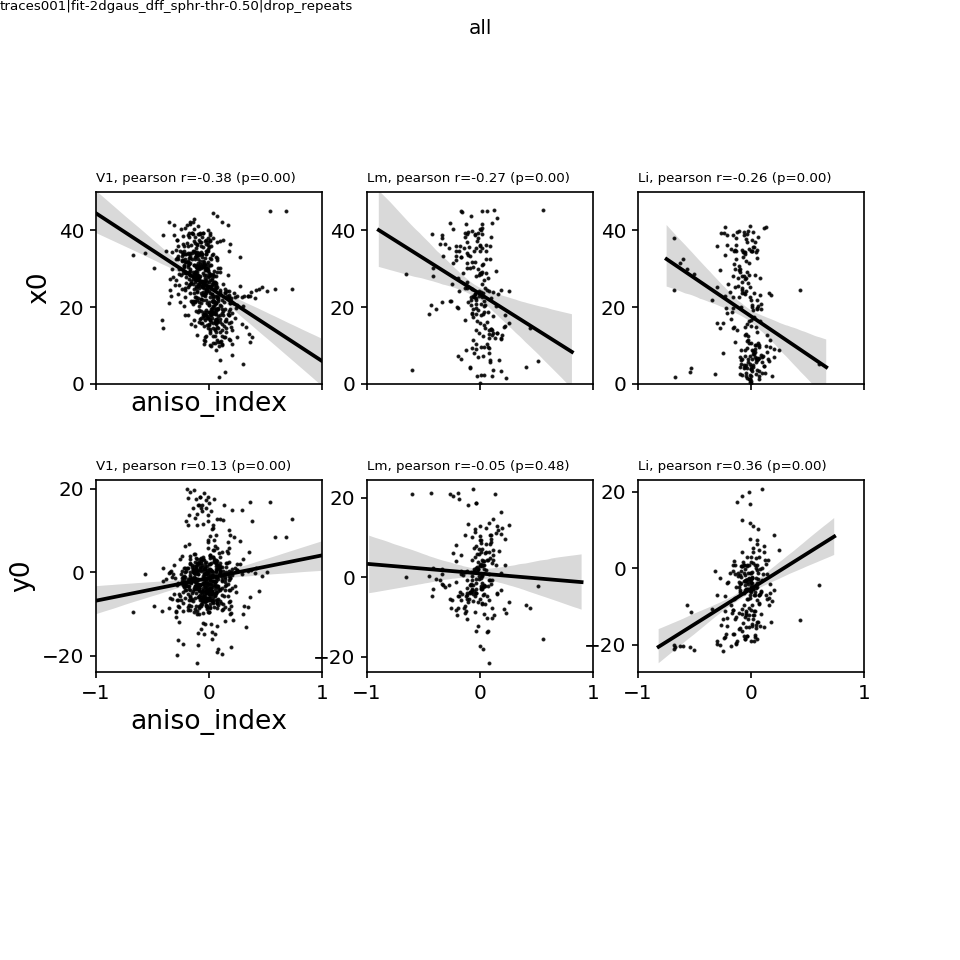

('/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff_sphr/general-stats', 'all_filter-None__spatial_distn_rfs_aniso_index_correlations_fullscreen')


In [54]:
rfname = 'all'
half_screen = False

# --------------------------------------------------------
if rfname=='mixed':
    expdf = mixdf.copy()
elif rfname == 'all':
    if filter_by is None:
        expdf = r_df.copy()
    else:
        expdf = alldf.copy()
else:
    expdf = r_df[(r_df['experiment']==rfname)].copy()
# --------------------------------------------------------
plotstr='halfscreen' if half_screen else 'fullscreen'

if half_screen:
    plotdf = expdf[expdf['x0']>0].copy()

fig, axn = pl.subplots(2, 3, figsize=(8,8), dpi=dpi, sharex=True, sharey=False)

scatter_kws={'s': 2}
for ai, (visual_area, vdf) in enumerate(plotdf.groupby(['visual_area'])):
    
    ax=axn[0, 2-ai]
    sns.regplot(x='aniso_index', y='x0', data=vdf, ax=ax, marker='o', color='k',
               scatter_kws=scatter_kws)
    ax.set_title(visual_area, loc='left')

    ax.set_ylim([0, 50])
    
    ax=axn[1, 2-ai]
    sns.regplot(x='aniso_index', y='y0', data=vdf, ax=ax, marker='o', color='k',
               scatter_kws=scatter_kws)
    

xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
for ai, (visual_area, vdf) in enumerate(plotdf.groupby(['visual_area'])):
    ax=axn[0, 2-ai]
    pearsons_r, pearsons_p = spstats.pearsonr(vdf['aniso_index'].values, vdf['x0'].values)
    #ax.text(xmin+0.1, ymax-8, 'pearson r=%.2f (p=%.2f)' % (pearsons_r, pearsons_p))
    pearson_str = 'pearson r=%.2f (p=%.2f)' % (pearsons_r, pearsons_p)
    ax.set_title('%s, %s' % (visual_area, pearson_str), loc='left', fontsize=8)
    
    ax=axn[1, 2-ai]
    pearsons_r, pearsons_p = spstats.pearsonr(vdf['aniso_index'].values, vdf['y0'].values)
    #ax.text(xmin+0.1, ymax-8, 'pearson r=%.2f (p=%.2f)' % (pearsons_r, pearsons_p))
    ax.set_xlim([-1, 1])
    pearson_str = 'pearson r=%.2f (p=%.2f)' % (pearsons_r, pearsons_p)
    ax.set_title('%s, %s' % (visual_area, pearson_str), loc='left', fontsize=8)
    
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.3, top=0.8, hspace=0.5)
pl.suptitle('%s' % (rfname))
putils.label_figure(fig, '%s' % (data_id))

for ax in axn[:, 1:].flat:
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    
figname = '%s__spatial_distn_rfs_%s_correlations_%s' % (prefix, hue_param, plotstr)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

In [56]:
genstats_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff_sphr/general-stats/drop_repeats_sphr'

## Plot x- and y-components of fit RFs

<IPython.core.display.Javascript object>


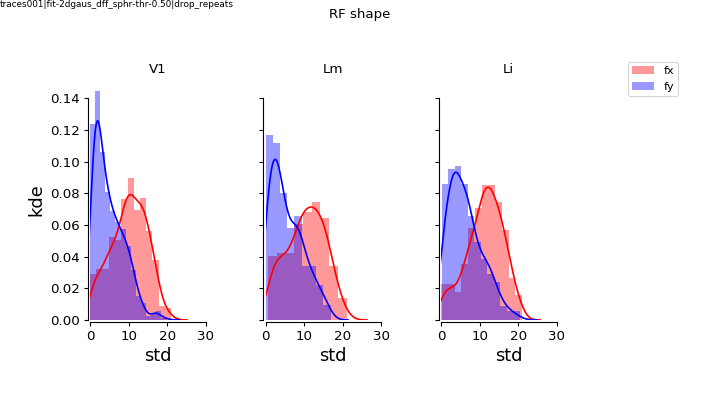

('/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff_sphr/general-stats/drop_repeats_sphr', 'all_filter-None__split_fxy_all')


In [58]:
split_components = True
curr_metric = 'std'

x_color = 'r'
y_color = 'b'

rfname='all'
# --------------------------------------------------------
if rfname=='mixed':
    expdf = mixdf.copy()
elif rfname == 'all':
    if filter_by is None:
        expdf = r_df.copy()
    else:
        expdf = alldf.copy()
else:
    expdf = r_df[(r_df['experiment']==rfname)].copy()
# --------------------------------------------------------

xlim = 25 if curr_metric=='std' else 60.
if split_components:
    xlim=35
else:
    xlim = 60 if scale_sigma else 30
sz_metric = 'f' if split_components else '%s_' % curr_metric

fig, axes = pl.subplots(1,3, figsize=(9,5), sharey=True, sharex=True)
for ax, visual_area in zip(axes.flat, visual_areas):
    g = expdf[expdf['visual_area']==visual_area].copy()
    
    sns.distplot(g['%sx' % sz_metric], color=x_color, ax=ax, label='%sx' % sz_metric)
    sns.distplot(g['%sy' % sz_metric], color=y_color, ax=ax, label='%sy' % sz_metric)
    ax.set_title(visual_area)
    
    ax.set_xlim([0, xlim])
    ax.set_xlabel(curr_metric)
sns.despine(trim=True, offset=2)
    
pl.subplots_adjust(wspace=0.3, right=0.8, top=0.8, bottom=0.2)
axes[0].set_ylabel('kde')
axes[2].legend(bbox_to_anchor=(1.8, 1.1))

label_figure(fig, data_id)
fig.suptitle('RF shape')

figname = '%s__split_%sxy_%s' % (prefix, sz_metric, rfname)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

# Look at all params

In [59]:
fieldnames = ['x0', 'y0', 'theta_c', '%s_x' % curr_metric, '%s_y' % curr_metric, 
              '%s_avg' % curr_metric, 'fx', 'fy', 'visual_area']
print(fieldnames)

['x0', 'y0', 'theta_c', 'std_x', 'std_y', 'std_avg', 'fx', 'fy', 'visual_area']


<IPython.core.display.Javascript object>


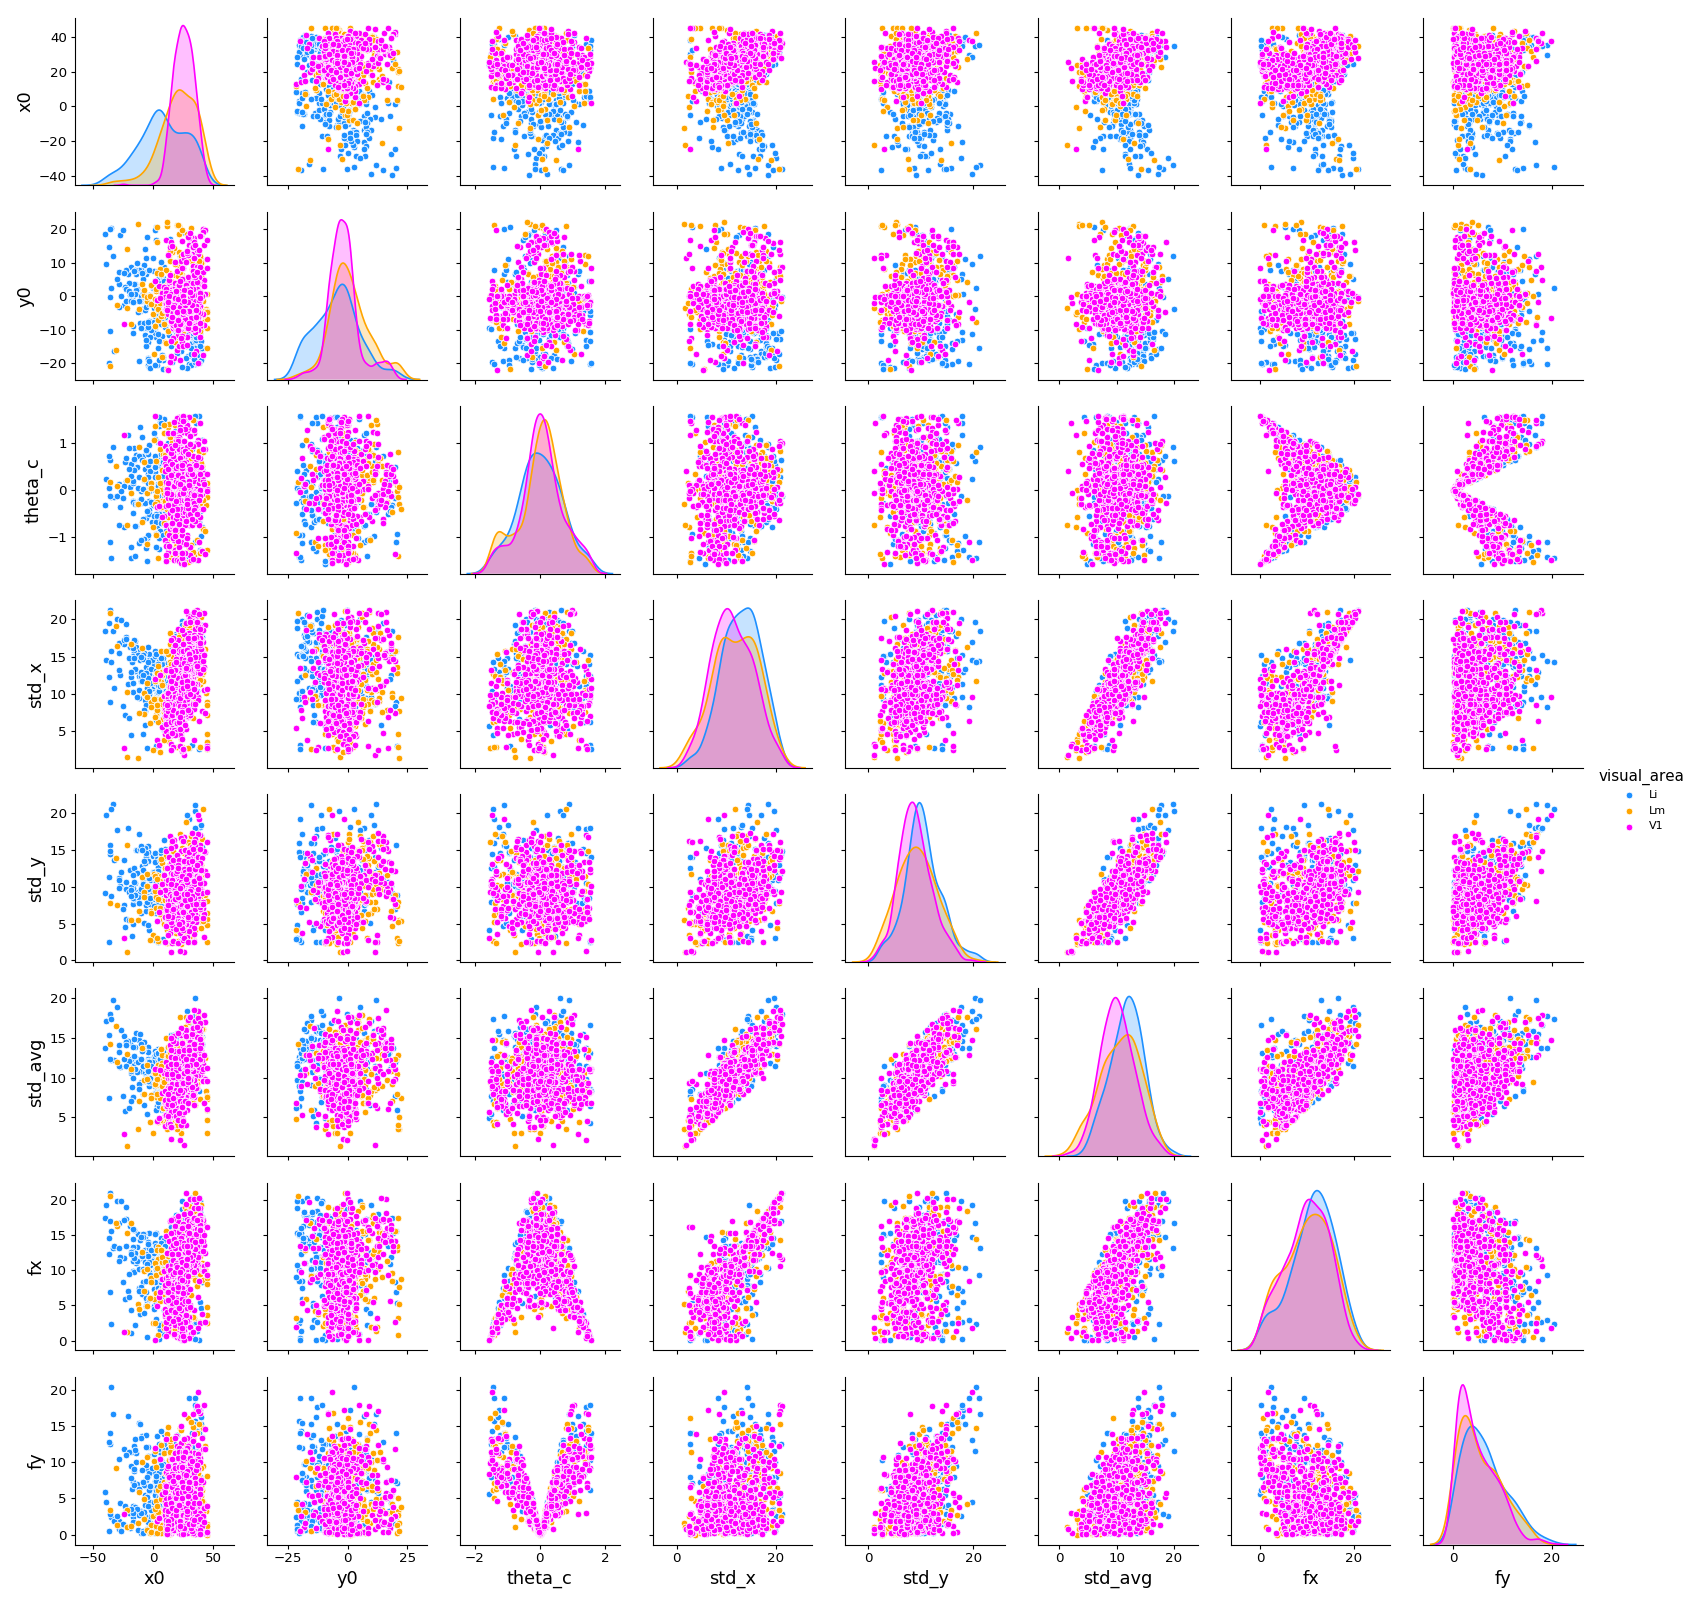

/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff_sphr/general-stats


In [66]:
# theta = 90 is vertically-long, 0 = horizontal
rfname ='all'
# --------------------------------------------------------
if rfname=='mixed':
    expdf = mixdf.copy()
elif rfname == 'all':
    if filter_by is None:
        expdf = r_df.copy()
    else:
        expdf = alldf.copy()
else:
    expdf = r_df[(r_df['experiment']==rfname)].copy()
# --------------------------------------------------------

sns.pairplot(expdf[fieldnames], hue='visual_area', palette=area_colors)
pl.savefig(os.path.join(dst_dir, '%s__all_params_pairplot.png' % (prefix)))
print(dst_dir)

## Check out thetas

<IPython.core.display.Javascript object>


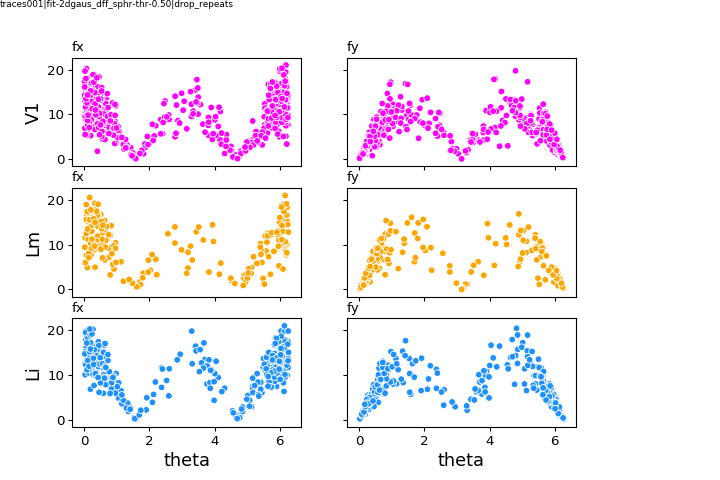

In [67]:
fig, axn = pl.subplots(3,2,figsize=(9,6), sharex=True, sharey=True)
for ri, visual_area in enumerate(visual_areas):
    g = expdf[expdf['visual_area']==visual_area]
    ax = axn[ri, 0]
    sns.scatterplot(x='theta', y='fx', hue='visual_area', palette=area_colors, data=g, ax=ax, legend=0)
    ax.set_ylabel(visual_area)
    ax.set_title('fx', loc='left')
    
    ax = axn[ri, 1]
    sns.scatterplot(x='theta', y='fy', hue='visual_area', palette=area_colors, data=g, ax=ax, legend=0)
    ax.set_title('fy', loc='left')

pl.subplots_adjust(wspace=0.2, right=0.8, left=0.1)
label_figure(fig, data_id)

pl.savefig(os.path.join(dst_dir, '%s__fx_fy_by_theta.svg' % (prefix)))

In [68]:
genstats_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff_sphr/general-stats/drop_repeats_sphr'

# Visualize general stats

### 1. Average RF size

<IPython.core.display.Javascript object>


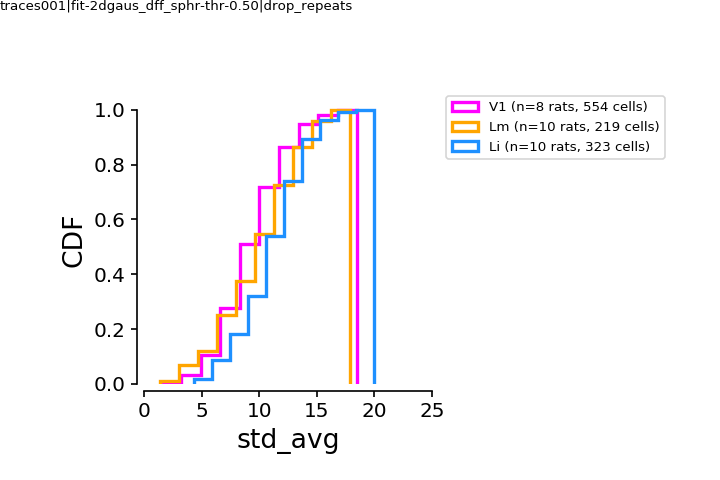

all_filter-None__std_avg__cdf


In [70]:
curr_metric = 'std_avg'
cdf = True
plot_type = 'cdf' if cdf else 'hist'
max_size = 50 if scale_sigma else 30

rfname ='all'
# --------------------------------------------------------
if rfname=='mixed':
    expdf = mixdf.copy()
elif rfname == 'all':
    if filter_by is None:
        expdf = r_df.copy()
    else:
        expdf = alldf.copy()
else:
    expdf = r_df[(r_df['experiment']==rfname)].copy()
# --------------------------------------------------------


fig, ax = pl.subplots(figsize=(6,4), dpi=dpi)
fig.patch.set_alpha(0)
ax.patch.set_alpha(0)
ax = rfutils.compare_rf_size(expdf, metric=curr_metric, cdf=cdf, ax=ax, alpha=1)
ax.set_xlim([0, 25])
sns.despine(ax=ax, trim=True, offset=4)

pl.subplots_adjust(right=0.6, top=0.8, bottom=0.2, left=0.2)

label_figure(fig, data_id)
figname = '%s__%s__%s' % (prefix, curr_metric, plot_type)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(figname)

## 2. Bar plot for fov averages

<IPython.core.display.Javascript object>


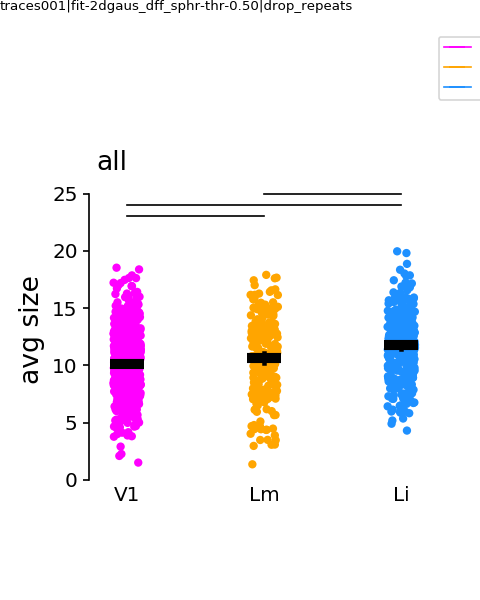

********* [all|mean std_avg] *********
[('V1', 'Lm')] p=0.010 (fdr_bh), reject H0=True
[('V1', 'Li')] p=0.000 (fdr_bh), reject H0=True
[('Lm', 'Li')] p=0.000 (fdr_bh), reject H0=True
all_filter-None__std_avg_mean-all-cells_multicomp-fdr_bh__


In [71]:
curr_metric = 'std_avg'
fov_means = False
plot_bar = False

multi_comp_test = 'fdr_bh' #'holm'
mean_metric = 'mean' # median
groupby = 'datakey' if fov_means else None
bar_str = 'bar' if plot_bar else ''
plot_str = '%s-by-%s' % (mean_metric, groupby) if fov_means else '%s-all-cells' % (mean_metric)

experiment = 'all'

rfname ='all'
# --------------------------------------------------------
if rfname=='mixed':
    expdf = mixdf.copy()
elif rfname == 'all':
    if filter_by is None:
        expdf = r_df.copy()
    else:
        expdf = alldf.copy()
else:
    expdf = r_df[(r_df['experiment']==rfname)].copy()
# --------------------------------------------------------


fig, ax = pl.subplots(figsize=(4,5), dpi=dpi, sharex=True, sharey=True)
fig.patch.set_alpha(0)
ax.patch.set_alpha(0)

# Average RF sizes for each FOV
grped = expdf.groupby(['visual_area', groupby]) if groupby is not None else expdf.groupby(['visual_area'])
mean_sizes = grped.median().reset_index() if mean_metric=='median' else grped.mean().reset_index()

# Plot means
if plot_bar:
    sns.barplot(x="visual_area", y=curr_metric, data=expdf, 
                ax=ax, order=visual_areas, ci=95,
                errcolor="k", edgecolor=('k', 'k', 'k'), 
                facecolor=(1,1,1,0), linewidth=2.5)
else:
    sns.pointplot(x="visual_area", y=curr_metric, data=expdf, 
                    ax=ax, order=visual_areas, ci=95,
                    markers='_', join=False, capsize=0., dodge=True,
                    scale=3, color='k')
# Plot points
plotdf = mean_sizes if fov_means else expdf
point_size = 10 if fov_means else 5
sns.stripplot(x='visual_area', y=curr_metric, data=plotdf, 
              zorder=-1, ax=ax, order=visual_areas, palette=area_colors,
              s=point_size, color=(1,1,1,0), dodge=True, #facecolor=(1,1,1,0),
              marker='o',linewidth=1, edgecolor='none')
if ai>0:
    ax.set_ylabel('');
ax.set_title(experiment, loc='left', fontsize=16)

# Get counts of samples for legend
legend_elements = aggr.get_counts_for_legend(expdf, area_colors=area_colors, markersize=10, marker='_')
ax.legend(handles=legend_elements, bbox_to_anchor=(1,1.5), fontsize=8)
ax.set_xlabel(''); ax.tick_params(axis='x', size=0);

# Annotate w stats
print("********* [%s|%s %s] *********" % (experiment, mean_metric, curr_metric))
y_loc = 16 if fov_means else 23
statresults = aggr.do_mannwhitney(expdf, metric=curr_metric, multi_comp_test=multi_comp_test)
aggr.annotate_stats_areas(statresults, ax, y_loc=y_loc, offset=1)

ylim = 0 if fov_means else 0
ax.set_ylim([ylim, ax.get_ylim()[-1]])
pl.subplots_adjust(top=0.7, bottom=0.2, left=0.2, right=0.9)
sns.despine(offset=4, trim=True, bottom=True)

ax.set_ylabel('avg size');
ax.set_title(experiment, loc='left', fontsize=16)



label_figure(fig, data_id)
figname = '%s__%s_%s_multicomp-%s__%s' % (prefix, curr_metric, plot_str, multi_comp_test, bar_str)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(figname)

## Distn of all rf sizes

<IPython.core.display.Javascript object>


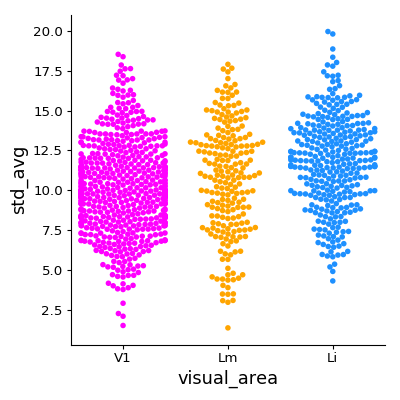

all_filter-None__distns_std_avg


In [72]:
curr_metric = 'std_avg'
plot_kind = 'swarm'

fg = sns.catplot(x="visual_area", y=curr_metric, data=expdf,# col='experiment',
           palette=area_colors, order=visual_areas, kind=plot_kind, dodge=True, 
                 edgecolor='w', linewidth=0, alpha=1)

figname = '%s__distns_%s' % (prefix, curr_metric)
fg.fig.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(figname)

In [565]:
reload(aggr)

<module 'pipeline.python.classifications.aggregate_data_stats' from '/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/aggregate_data_stats.py'>

## Look at N cells fit 

<IPython.core.display.Javascript object>


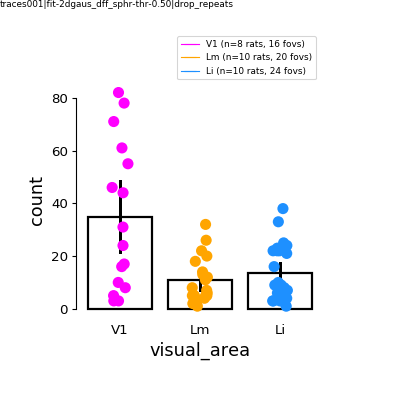

********* n_cells **********
[('V1', 'Lm')] p=0.015 (fdr_bh), reject H0=True
[('V1', 'Li')] p=0.015 (fdr_bh), reject H0=True
[('Lm', 'Li')] p=0.254 (fdr_bh), reject H0=False
****************************
('/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff_sphr/general-stats', 'all_filter-None__n_cells_avg-fov_multicomp-fdr_bh')


In [74]:
curr_metric = 'n_cells'

rfname ='all'
# --------------------------------------------------------
if rfname=='mixed':
    expdf = mixdf.copy()
elif rfname == 'all':
    if filter_by is None:
        expdf = r_df.copy()
    else:
        expdf = alldf.copy()
else:
    expdf = r_df[(r_df['experiment']==rfname)].copy()
# --------------------------------------------------------

countdf = expdf.groupby([ 'visual_area', 'animalid', 'datakey']).count()['cell'].reset_index()
countdf.rename(columns={'cell': 'n_cells'}, inplace=True)

fg = sns.catplot(x="visual_area", y=curr_metric, data=countdf, #hue="experiment", 
               kind = 'bar',
                errcolor="k", edgecolor=('k', 'k', 'k'), order=visual_areas,
                facecolor=(1,1,1,0), linewidth=2, zorder=0, legend=0) #, ax=ax)
sns.stripplot(x='visual_area', y=curr_metric, data=countdf, #hue='experiment',
             order=visual_areas, ax=fg.ax, palette=area_colors, dodge=True,
             size=10)
fg.ax.tick_params(axis='x', size=0)
fg.ax.set_ylabel('count')

pl.subplots_adjust(top=0.8, bottom=0.2, left=0.2, right=0.8)
sns.despine(offset=4, trim=True, bottom=True, ax=fg.ax)
fg.ax.tick_params(axis='x', size=0)

# Get counts of samples for legend
legend_elements = aggr.get_counts_for_legend(countdf, area_colors=area_colors, markersize=10, marker='_')
fg.ax.legend(handles=legend_elements, bbox_to_anchor=(1,1.2), fontsize=8)


print("********* %s **********" % (curr_metric))
statresults = aggr.do_mannwhitney(countdf, metric=curr_metric, multi_comp_test=multi_comp_test)
aggr.annotate_stats_areas(statresults, ax, lw=1, color='k', 
                         visual_areas=['V1', 'Lm', 'Li'])
print("****************************")

    
#fg.ax.set_title('N cells with good fits(within 95% CI)', loc='left')
label_figure(fg.fig, data_id)

figname = '%s__%s_avg-fov_multicomp-%s' % (prefix, curr_metric, multi_comp_test)
fg.fig.savefig(os.path.join(dst_dir, '%s.svg' % figname))

print(dst_dir, figname)


## All fit params

In [76]:
curr_metric = 'std'
params = ['x0', 'y0', 'theta_c', '%s_x' % curr_metric, '%s_y' % curr_metric, 
              '%s_avg' % curr_metric, 'fx', 'fy', 'visual_area']
print(params)

['x0', 'y0', 'theta_c', 'std_x', 'std_y', 'std_avg', 'fx', 'fy', 'visual_area']


<IPython.core.display.Javascript object>


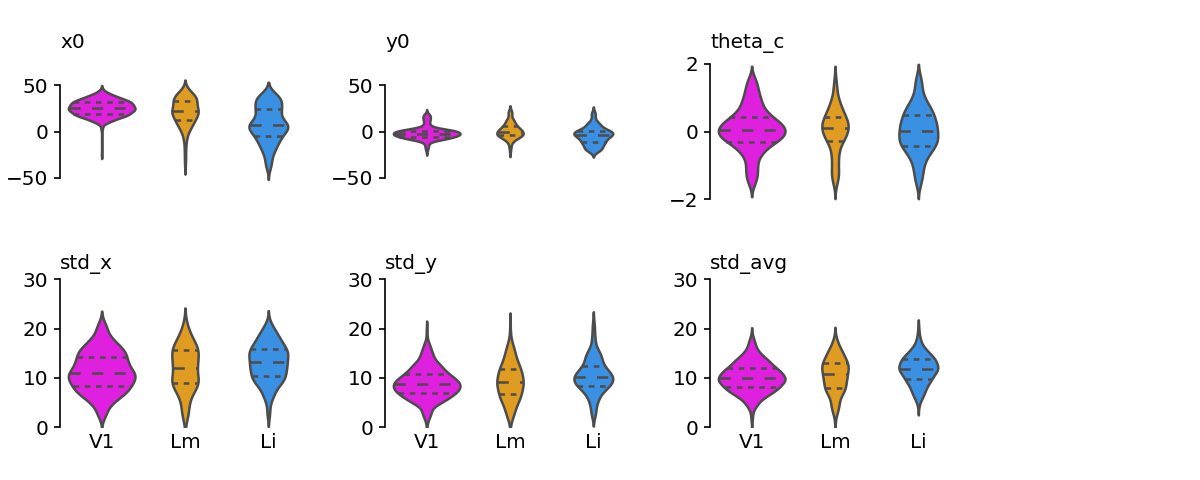

('/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff_sphr/general-stats', 'all_filter-None__all-metrics__violin')


In [77]:
plot_type = 'violin'

rfname ='all'
# --------------------------------------------------------
if rfname=='mixed':
    expdf = mixdf.copy()
elif rfname == 'all':
    if filter_by is None:
        expdf = r_df.copy()
    else:
        expdf = alldf.copy()
else:
    expdf = r_df[(r_df['experiment']==rfname)].copy()
# --------------------------------------------------------

fig, axes = pl.subplots(2, 3, figsize=(10,4), dpi=dpi)
fig.patch.set_alpha(0)
for ai, (ax, param) in enumerate(zip(axes.flat, params)):
    if plot_type=='violin':
        sns.violinplot(x='visual_area', y=param, data=expdf, ax=ax,
                      palette=area_colors, order=visual_areas,
                       scale='count', inner='quartile')
    else:
        sns.swarmplot(x='visual_area', y=param, data=expdf, ax=ax,
                      palette=area_colors, dodge=True, order=visual_areas)
    if ai<3:
        ax.set_xticklabels('')
    ax.set_xlabel('')
    ax.tick_params(axis='x', size=0)

    ax.set_ylabel('')
    ax.set_title(param, fontsize=12, loc='left')
    
    if param=='theta':
        ax.set_ylim([-np.pi, 3*np.pi])
    elif param in ['x0','y0']:
        ax.set_ylim([-80, 80])
    elif 'fwhm' in param:
        ax.set_ylim([0, 60])
    elif 'std' in param:
        ax.set_ylim([0, 30])
    sns.despine(trim=True, ax=ax, bottom=True)
    
pl.subplots_adjust(wspace=0.3, hspace=0.5, right=0.8, left=0.05)

# Save
figname = '%s__all-metrics__%s' % (prefix, plot_type)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))

print(dst_dir, figname)    

# Compare cortical position vs. VF position

In [21]:
# def get_fov_coordinates(animalid, session, fov, rffits):

#     S = util.Session(animalid, session, fov)
#     experiment_list = S.get_experiment_list()
#     if 'rfs10' in experiment_list:
#         S.get_experiment_data(experiment='rfs10')
#         rf_exp_name = 'rfs10'
#     else:
#         S.get_experiment_data(experiment='rfs')
#         rf_exp_name= 'rfs'
    
#     masks, zimg = S.load_masks()
#     roi_contours = coords.contours_from_masks(masks)
#     # Convert to brain coords
#     fov_pos_x, rf_xpos, xlim, fov_pos_y, rf_ypos, ylim = coords.get_roi_position_um(rffits, roi_contours, 
#                                                                          rf_exp_name=rf_exp_name,
#                                                                          convert_um=True)
    
#     posdf = pd.DataFrame({'xpos_fov': fov_pos_y,
#                           'xpos_rf': rf_xpos,
#                           'ypos_fov': fov_pos_x,
#                           'ypos_rf': rf_ypos,
#                          'visual_area': [visual_area for _ in range(len(fov_pos_x))],
#                          'animalid': [animalid for _ in range(len(fov_pos_x))],
#                          'session': [session for _ in range(len(fov_pos_x))],
#                          'fov': [fov for _ in range(len(fov_pos_x))]})
#     return posdf


#### Create output subdir

In [79]:
scatter_dir = os.path.join(outdir, 'scatter')
if not os.path.exists(scatter_dir):
    os.makedirs(scatter_dir)
print(scatter_dir)

/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff_sphr/scatter


#### Load converted RF positions

In [150]:
from pipeline.python.rois.utils import load_roi_coords

In [151]:
reliable_str = 'reliable' if reliable_only else 'allfit'

df_fpath = os.path.join(outdir, 'fits_and_coords_%s_%s_%s.pkl' % (filter_by, reliable_str, rfname))
print(df_fpath)

get_positions = False

if os.path.exists(df_fpath) and get_positions is False:
    print("Loading existing RF coord conversions...")
    try:
        with open(df_fpath, 'rb') as f:
            df = pkl.load(f)
    except Exception as e:
        get_positions = True
print(get_positions)

/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/fits_and_coords_drop_repeats_reliable_rfs10.pkl


In [155]:

if get_positions:
    print("Calculating RF coord conversions...")
    pos_params = ['fov_xpos', 'fov_xpos_pix', 'fov_ypos', 'fov_ypos_pix', 'ml_pos','ap_pos']
    for p in pos_params:
        expdf[p] = ''
    p_list=[]
    for (animalid, session, fovnum), g in expdf.groupby(['animalid', 'session', 'fovnum']):
        cell_ids = g['cell'].unique()
        fcoords = load_roi_coords(animalid, session, 'FOV%i_zoom2p0x' % fovnum, 
                                  traceid=traceid, create_new=False)
        p_ = fcoords['roi_positions'].loc[cell_ids]
        for p in pos_params:
            expdf[p][g.index] = p_[p]

    with open(df_fpath, 'wb') as f:
        pkl.dump(expdf, f, protocol=pkl.HIGHEST_PROTOCOL)
    

In [156]:
expdf.groupby(['visual_area']).count()

r2  fwhm_x  fwhm_y  theta   x0   y0  animalid  cell  datakey  \
visual_area                                                                  
Li           410     410     410    410  410  410       410   410      410   
Lm           170     170     170    170  170  170       170   170      170   
V1           527     527     527    527  527  527       527   527      527   

             experiment   ...     fx   fy  ratio_xy  theta_c  fov_xpos  \
visual_area               ...                                            
Li                  410   ...    410  410       410      410       410   
Lm                  170   ...    170  170       170      170       170   
V1                  527   ...    527  527       527      527       527   

             fov_xpos_pix  fov_ypos  fov_ypos_pix  ml_pos  ap_pos  
visual_area                                                        
Li                    410       410           410     410     410  
Lm                    170       170           170     170     170  
V1                    527       527           527     527     527  

[3 rows x 28 columns]

In [157]:
df.groupby(['visual_area']).count()

r2  fwhm_x  fwhm_y  theta   x0   y0  animalid  cell  datakey  \
visual_area                                                                  
Li           410     410     410    410  410  410       410   410      410   
Lm           170     170     170    170  170  170       170   170      170   
V1           527     527     527    527  527  527       527   527      527   

             experiment   ...     fx   fy  ratio_xy  theta_c  fov_xpos  \
visual_area               ...                                            
Li                  410   ...    410  410       410      410       410   
Lm                  170   ...    170  170       170      170       170   
V1                  527   ...    527  527       527      527       527   

             fov_xpos_pix  fov_ypos  fov_ypos_pix  ml_pos  ap_pos  
visual_area                                                        
Li                    410       410           410     410     410  
Lm                    170       170           170     170     170  
V1                    527       527           527     527     527  

[3 rows x 28 columns]

## Pairwise distances

In [30]:
from scipy.spatial.distance import pdist
#dists = skmetrics.pairwise.euclidean_distances(tmpd, Y=None) #, metric='euclidean')
import itertools

from pipeline.python.classifications import evaluate_receptivefield_fits as evalrf
from sklearn.linear_model import LinearRegression
import scipy.stats as spstats
import sklearn.metrics as skmetrics #import mean_squared_error

#### Look at PW distances of by dataset

In [31]:
min_cells = 5

pair_names = [('fov_x', 'ml_pos'), ('fov_y', 'ap_pos'), ('rf_x', 'x0'), ('rf_y', 'y0')]

d_list = []
# Get all pairwise distances between rf positions:
for (visual_area, animalid, session, fovnum), g in expdf.groupby(['visual_area', 'animalid', 'session', 'fovnum']):
    if g.shape[0] <= min_cells:
        continue
        
    diffs={}
    for (d1, d2) in pair_names:
        xx = g[d2].values
        diffs[d1] = np.abs([t1-t2 for i, t1 in enumerate(xx) for t2 in xx[i + 1:]])
        npairs = len(list(itertools.combinations(range(len(xx)), 2)))
        assert len(diffs[d1]) == npairs, "bad combos"

    d_df = pd.DataFrame(diffs)
    d_df['animalid'] = [animalid for _ in np.arange(0, npairs)]
    d_df['session'] = [session for _ in np.arange(0, npairs)]
    d_df['fovnum'] = [fovnum for _ in np.arange(0, npairs)]
    d_df['visual_area'] = [visual_area for _ in np.arange(0, npairs)]
    d_df['datakey'] = ['%s_%s_fov%i' % (animalid, session, fovnum) for _ in np.arange(0, npairs)]

    d_list.append(d_df)
    
diff_df = pd.concat(d_list, axis=0).reset_index(drop=True)

In [32]:
print(diff_df.shape)
diff_df.head()

(39987, 9)


fov_x       fov_y       rf_x       rf_y animalid   session  fovnum  \
0   74.245010  235.059100  42.313861  10.856852    JC089  20190522       1   
1  188.468102  262.713112  53.584878  13.892473    JC089  20190522       1   
2  296.980039  182.055577  41.613033  13.656004    JC089  20190522       1   
3  390.262231  133.661057  32.783722  22.889158    JC089  20190522       1   
4  371.225049  271.931115  37.542110  13.579386    JC089  20190522       1   

  visual_area              datakey  
0          Li  JC089_20190522_fov1  
1          Li  JC089_20190522_fov1  
2          Li  JC089_20190522_fov1  
3          Li  JC089_20190522_fov1  
4          Li  JC089_20190522_fov1

In [33]:
diff_df[['visual_area', 'datakey']].drop_duplicates().groupby(['visual_area']).count()

datakey
visual_area         
Li                14
Lm                 7
V1                 6

## Split PW dist calculation by azimuth/elevation

<IPython.core.display.Javascript object>


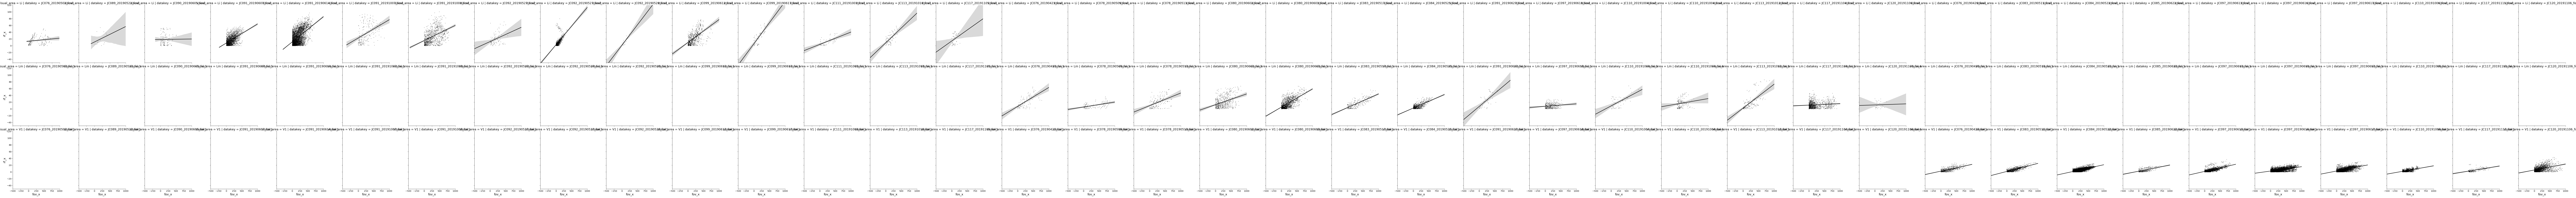

In [79]:
# # Plot regression w/ CI
# xvar = 'fov'
# yvar = 'rf'


# g = sns.lmplot('%s_x' % xvar, '%s_x' % yvar, data=diff_df, 
#                row='visual_area', col='datakey', #col_wrap=6,
#           scatter_kws={'s': 1,
#                       'marker':'+',
#                       'color': 'k'},
#           line_kws={'color': 'k'})
# g.fig.patch.set_alpha(1)
# g.set(xlim=(-500, 1000), ylim=(-50, 120))


<IPython.core.display.Javascript object>


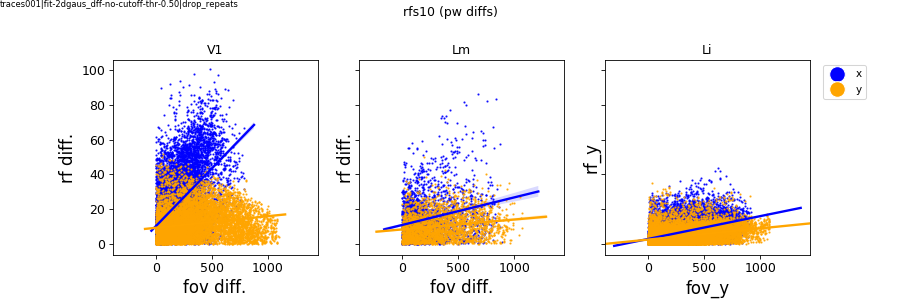

In [35]:
fig, axn = pl.subplots(1,3, sharex=True, sharey=True, figsize=(12,4))
for ci, (visual_area, g) in enumerate(diff_df.groupby(['visual_area'])):
    for (axi, col) in zip(['x', 'y'], ['blue', 'orange']):
        
        sns.regplot('fov_%s' % axi, 'rf_%s' % axi, data=g, ax=axn[ci],
                   scatter=True, color=col, truncate=False,
                   marker='.', scatter_kws={'s': 5})
    axn[2-ci].set_title(visual_area)
    axn[2-ci].set_xlabel('fov diff.')
    axn[2-ci].set_ylabel('rf diff.')
    
# legend
leg_elements = [Line2D([0], [0], marker='o', color='w', label='x',
                          markerfacecolor='blue', markersize=15),
               Line2D([0], [0], marker='o', color='w', label='y',
                          markerfacecolor='orange', markersize=15)]
axn[-1].legend(handles=leg_elements, bbox_to_anchor=(1.3, 1))
pl.suptitle('%s (pw diffs)' % rfname)

label_figure(fig, data_id)
pl.subplots_adjust(top=0.8, bottom=0.15)
figname = '_%s_pwdiffs_split_xy_by_visual_area2' % rfname
pl.savefig(os.path.join(genstats_dir, '%s.svg' % figname))

## Linear fit

In [37]:
# Plot regression w/ CI
xvar = 'fov'
yvar = 'rf'
d_list=[]
i=0
for (visual_area, animalid, session, fovnum, datakey), currdf in diff_df.groupby(['visual_area', 'animalid', 'session', 'fovnum', 'datakey']):
    for axi in ['x', 'y']:
        
        xv = currdf['fov_%s' % axi].values
        yv = currdf['rf_%s' % axi].values
        
        fitv, regr = evalrf.fit_linear_regr(xv, yv, return_regr=True, model='ridge')
        # ax.plot(xv, fitv, curr_color)
        rmse = np.sqrt(skmetrics.mean_squared_error(yv, fitv))
        r2 = skmetrics.r2_score(yv, fitv)
        pearson_p, pearson_r = spstats.pearsonr(xv, yv)
            
        
        tmpdf = pd.DataFrame({'slope': float(regr.coef_),
                              'R2': r2,
                              'RMSE': rmse,
                              'axis': axi,
                              'pearson_p': pearson_p,
                              'pearson_r': pearson_r,
                              'n_cells': expdf[expdf['datakey']==datakey].shape[0], #len(yv),
                              'animalid': animalid, 'session': session, 'fovnum': fovnum,
                              'visual_area': visual_area,
                              'datakey': '%s_%s_fov%i' % (session, animalid, fovnum)}, index=[i])
        
        d_list.append(tmpdf)
        i+=1
pwslopes = pd.concat(d_list, axis=0).reset_index(drop=True)


<IPython.core.display.Javascript object>


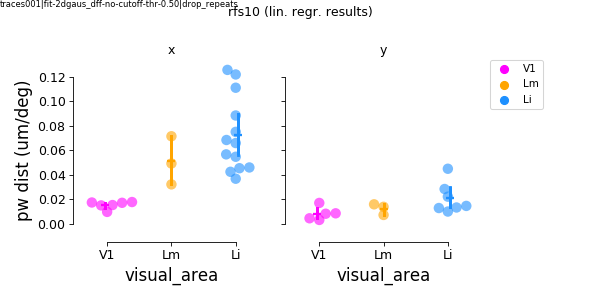

('/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/general-stats/drop_repeats', '_rfs10_regr_pw_dists_rfpos_vs_fovpos_split_xy_R2-0.04__drop_repeats_reliable')


In [38]:
metric = 'slope'
fig, axn = pl.subplots(1, 2, sharex=True, sharey=True, figsize=(8,4))

R2_thr = 0.04
thr_str = 'R2-%.2f' % R2_thr
curr_df = pwslopes[pwslopes['R2'] > R2_thr]

for ax, axi in zip(axn.flat, ['x', 'y']):
    
    axdf = curr_df[(curr_df['axis']==axi)]
    
    g = sns.swarmplot(x='visual_area', y=metric, hue='visual_area', ax=ax,
                      palette=area_colors, data=axdf.sort_values(by='visual_area', ascending=False),
                     marker='o', facecolor='none', s=10,  alpha=0.6)

    for ai, visual_area in enumerate(visual_areas):
        mval =  axdf[axdf['visual_area']==visual_area][metric].mean()

        sns.pointplot(x='visual_area', y=metric, hue='visual_area', legend=False,
                     data=axdf.sort_values(by='visual_area', ascending=False),
                     ci=95, capsize=0., alpha=0.7,
                     palette=area_colors, dodge=True, markers='_', join=False, ax=ax)
    ax.set_title(axi)
    ax.set_ylabel('')

    if axi == 'x':
        ax.legend_.remove()
    else:
        # Get the handles and labels. For this example it'll be 2 tuples
        # of length 4 each.
        handles, labels = ax.get_legend_handles_labels()

        # When creating the legend, only use the first two elements
        # to effectively remove the last two.
        l = pl.legend(handles[0:3], labels[0:3], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

axn[0].set_ylabel('pw dist (um/deg)')
sns.despine(trim=True, offset=2)
pl.subplots_adjust(wspace=0.1, right=0.8, top=0.8, bottom=0.2)
fig.suptitle('%s (lin. regr. results)' % rfname)

label_figure(fig, data_id)

figname = '_%s_regr_pw_dists_rfpos_vs_fovpos_split_xy_%s__%s' % (rfname, thr_str, filter_str)
pl.savefig(os.path.join(genstats_dir, '%s2.svg' % figname))
print(genstats_dir, figname)

<IPython.core.display.Javascript object>


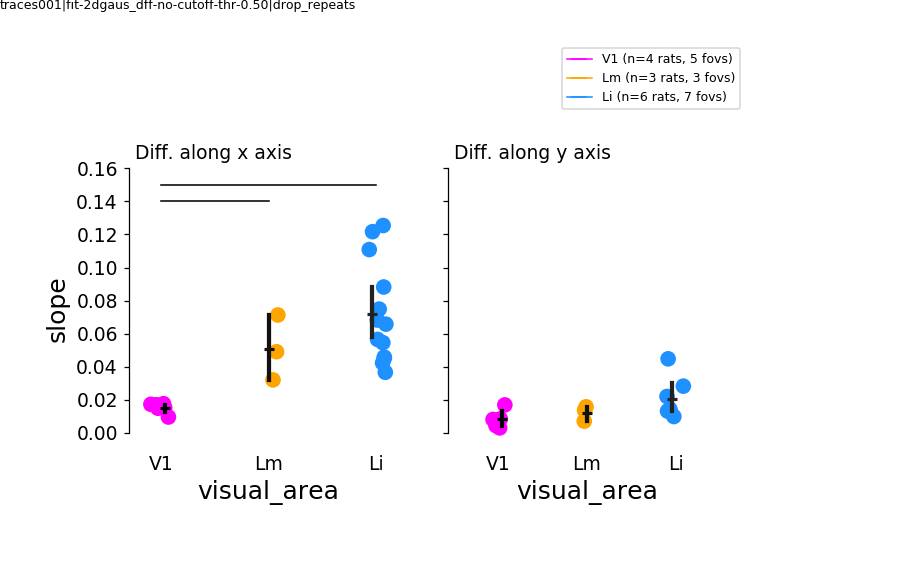

********* slope **********
[('V1', 'Lm')] p=0.028 (holm), reject H0=True
[('V1', 'Li')] p=0.001 (holm), reject H0=True
[('Lm', 'Li')] p=0.173 (holm), reject H0=False
****************************
********* slope **********
[('V1', 'Lm')] p=0.494 (holm), reject H0=False
[('V1', 'Li')] p=0.052 (holm), reject H0=False
[('Lm', 'Li')] p=0.494 (holm), reject H0=False
****************************
_rfs10_fovdiff_vs_rfdiffs_R2-0.05_multicomp-holm_ci


In [39]:
curr_metric = 'slope'
multi_comp_test = 'holm'
plot_bar = False


R2_thr = 0.05
thr_str = 'R2-%.2f' % R2_thr
curr_df = pwslopes[pwslopes['R2'] > R2_thr]

ymax = curr_df.max()[curr_metric] + 0.3

fig, axn = pl.subplots(1, 2, figsize=(8,5), dpi=dpi, sharey=True)
fig.patch.set_alpha(0)
for ai, (ax, axi) in enumerate(zip(axn, ['x', 'y'])):
    ax.patch.set_alpha(0)
    axdf = curr_df[(curr_df['axis']==axi)]
    if plot_bar:
        sns.barplot(x="visual_area", y=curr_metric, data=axdf, 
                    ax=ax, order=visual_areas, ci=95,
                    errcolor="k", edgecolor=('k', 'k', 'k'), 
                    facecolor=(1,1,1,0), linewidth=2.5)
    else:
        sns.pointplot(x='visual_area', y=curr_metric, data=axdf, 
                      hue='visual_area', legend=False, order=visual_areas,
                      ci=95, capsize=0., alpha=0.7, color='k', #palette=area_colors, 
                      dodge=True, markers='_', join=False, ax=ax)
        
    sns.stripplot(x='visual_area', y=curr_metric, data=axdf, ax=ax,
                  zorder=0, s=10, palette=area_colors,
                  order=visual_areas, color=(1,1,1,0), 
                  dodge=True, edgecolor='none',  #facecolor=(1,1,1,0),
                  marker='o',linewidth=1)

    print("********* %s **********" % (curr_metric))
    statresults = aggr.do_mannwhitney(axdf, metric=curr_metric, multi_comp_test=multi_comp_test)
    aggr.annotate_stats_areas(statresults, ax, offset=0.01, y_loc=0.14)
    print("****************************")

    pl.subplots_adjust(top=0.8, bottom=0.2, left=0.2, right=0.8)
    ax.tick_params(axis='x', size=0)
    ax.set_title('Diff. along %s axis' % axi, loc='left', fontsize=12)
    ax.set_ylim([-0.01, 0.16])
    if ai==0:
        ax.legend_.remove()
    else:
        ax.set_ylabel('')

sns.despine(offset=4, trim=True, bottom=True)

# Get counts of samples for legend
legend_elements = aggr.get_counts_for_legend(axdf, area_colors=area_colors, markersize=10, marker='_')
ax.legend(handles=legend_elements, bbox_to_anchor=(1.1,1.45), fontsize=8)
pl.subplots_adjust(left=0.15, top=0.7)
label_figure(fig, data_id)
figname = '_%s_fovdiff_vs_rfdiffs_%s_multicomp-%s_ci' % (rfname, thr_str, multi_comp_test)
pl.savefig(os.path.join(genstats_dir, '%s2.svg' % figname))
print(figname)


In [638]:
area_colors

{'Li': 'dodgerblue', 'Lm': 'orange', 'V1': 'magenta'}

# Plot Center of mass for each FOV

In [77]:
reload(util)
reload(putils)

<module 'pipeline.python.utils' from '/home/julianarhee/Repositories/2p-pipeline/pipeline/python/utils.py'>

In [80]:
expdf.head()

r2     fwhm_x     fwhm_y     theta         x0         y0 animalid  \
22  0.585001  46.670332  36.780253  6.081151 -29.065480 -11.080597    JC089   
23  0.696801  45.149795  27.452993  0.127034  13.248381 -21.937449    JC089   
24  0.876773  28.931146  20.644447  6.106297  24.519398   2.811875    JC089   
25  0.529471  29.483275  25.960252  6.261067  12.547553   2.575407    JC089   
26  0.767423  31.775266  30.710669  0.442568   3.718242  11.808561    JC089   

    cell              datakey experiment   ...            fx        fy  \
22    71  20190522_JC089_fov1      rfs10   ...     19.455779  3.985095   
23    89  20190522_JC089_fov1      rfs10   ...     19.057864  2.434098   
24    99  20190522_JC089_fov1      rfs10   ...     12.119023  2.166355   
25   113  20190522_JC089_fov1      rfs10   ...     12.543006  0.277473   
26   116  20190522_JC089_fov1      rfs10   ...     12.218671  5.790689   

    ratio_xy   theta_c  fov_xpos  fov_xpos_pix  fov_ypos  fov_ypos_pix  \
22  1.268896 -0.202034   433.246           188   415.011           218   
23  1.644622  0.127034   668.305           290   489.256           257   
24  1.401401 -0.176888   695.959           302   603.479           317   
25  1.135708 -0.022118   615.302           267   711.991           374   
26  1.034665  0.442568   566.907           246   805.273           423   

     ml_pos   ap_pos  
22  557.789  744.354  
23  483.544  509.295  
24  369.321  481.641  
25  260.809  562.298  
26  167.527  610.693  

[5 rows x 29 columns]

In [162]:
np.where(expdf!=df)


(array([], dtype=int64), array([], dtype=int64))

In [412]:
reload(aggr)
reload(putils)
reload(rfutils)

<module 'pipeline.python.classifications.rf_utils' from '/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/rf_utils.pyc'>

In [413]:
screeninfo = aggr.get_aggregate_stimulation_info(expdf)
# s_list = []
# #stimcoords = {}
# #screeninfo = {}
# for (visual_area, animalid, session, fovnum), tmpd in expdf.groupby(['visual_area', 'animalid', 'session', 'fovnum']):
#     datakey = '_'.join([session, animalid, 'fov%i' % fovnum])
#     S = util.Session(animalid, session, 'FOV%i_zoom2p0x' % fovnum)
#     xpos, ypos = S.get_stimulus_coordinates()
#     #stimcoords[datakey] = (xpos, ypos) #[(xpos, ypos) for _ in range(tmpd.shape[0])])
#     screenleft, screenright = S.screen['linminW'], S.screen['linmaxW']
#     screenbottom, screentop = S.screen['linminH'], S.screen['linmaxH']
#     screenaspect = S.screen['resolution'][0] / S.screen['resolution'][1]
#     #screeninfo[fovnum] = (screenleft, screenright, screenbottom, screentop, screenaspect) #for _ in range(tmpd.shape[0])])
    
#     s_ = pd.DataFrame({'xpos': xpos, 'ypos': ypos,
#                   'screen_left': screenleft,
#                   'screen_right': screenright,
#                   'screen_top': screentop,
#                   'screen_bottom': screenbottom,
#                   'screen_xres': S.screen['resolution'][0],
#                   'screen_yres': S.screen['resolution'][1],
#                  }, index=[i])
#     metadict={'visual_area': visual_area, 'animalid': animalid, 
#           'session': session, 'fovnum': fovnum, 'datakey': datakey}
#     s_ = putils.add_meta_to_df(s_, metadict)
#     s_list.append(s_)
# screeninfo = pd.concat(s_list, axis=0)

Creating session object [JC089|20190522|FOV1_zoom2p0x]
---> (warning): no anatomicals for (JC089|20190522|FOV1_zoom2p0x)
[JC089|20190522] not found: blobs
Creating gratings object [JC089|20190522|FOV1_zoom2p0x|traces001]
... getting stimulus info for: combined_gratings_static
(          aspect direction luminance ori position   sf size speed  stimtype  \
config001      1         0      None   0   (0, 0)  0.1  200    10  gratings   
config002      1         0      None   0   (0, 0)  0.1  200    20  gratings   
config003      1         0      None   0   (0, 0)  0.5  200    10  gratings   
config004      1         0      None   0   (0, 0)  0.5  200    20  gratings   
config005      1         0      None  45   (0, 0)  0.1  200    10  gratings   

          xpos ypos  
config001    0    0  
config002    0    0  
config003    0    0  
config004    0    0  
config005    0    0  , array([0.0], dtype=object), array([0.0], dtype=object))
Stimuli presented at coords: (0, 0)
Creating session objec

KeyboardInterrupt: 

In [83]:
print(expdf[['visual_area', 'datakey']].drop_duplicates().groupby(['visual_area']).count())

print(screeninfo[['visual_area', 'datakey']].drop_duplicates().groupby(['visual_area']).count())


             datakey
visual_area         
Li                15
Lm                 8
V1                 6
             datakey
visual_area         
Li                15
Lm                 8
V1                 6


## Visualize all RF positions, and CoM by FOV

<IPython.core.display.Javascript object>


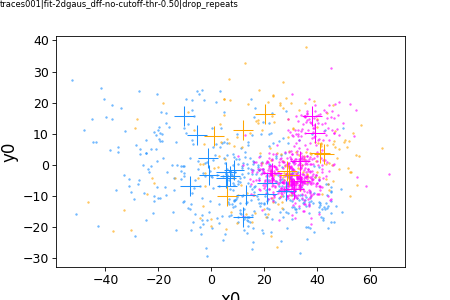

('/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/general-stats/drop_repeats', 'all_rfs_with_CoM__rfs10_R2-0.05')


In [430]:
n_cells = []

fig, ax = pl.subplots(figsize=(6,4))
for (visual_area, animalid, session, fovnum), tmpd in expdf.groupby(['visual_area', 'animalid', 'session', 'fovnum']):
    sns.scatterplot('x0', 'y0', data=tmpd, ax=ax, color=area_colors[visual_area],
                   s=10, marker='.', alpha=0.5, edgecolor=area_colors[visual_area])
    x = tmpd['x0'].values
    y=tmpd['y0'].values
    m=np.ones(tmpd['x0'].shape)
    cgx = np.sum(x*m)/np.sum(m)
    cgy = np.sum(y*m)/np.sum(m)
    #print('The center of mass: (%.2f, %.2f)' % (cgx, cgy))
    ax.plot(cgx, cgy, marker='+', markersize=20, 
            color=area_colors[visual_area], alpha=1) #c=rgba_colors, 
    
label_figure(fig, data_id)
figname = 'all_rfs_with_CoM__%s_%s' % (rfname, thr_str)
pl.savefig(os.path.join(genstats_dir, '%s.svg' % figname))
print(genstats_dir, figname)

#### Plot each visual area's stuff separately

In [431]:
screenleft = float(screeninfo['screen_left'].unique())
screenright = float(screeninfo['screen_right'].unique())
screentop = float(screeninfo['screen_top'].unique())
screenbottom = float(screeninfo['screen_bottom'].unique())
screenaspect = float(screeninfo['screen_xres'].unique()) / float(screeninfo['screen_yres'].unique())


<IPython.core.display.Javascript object>


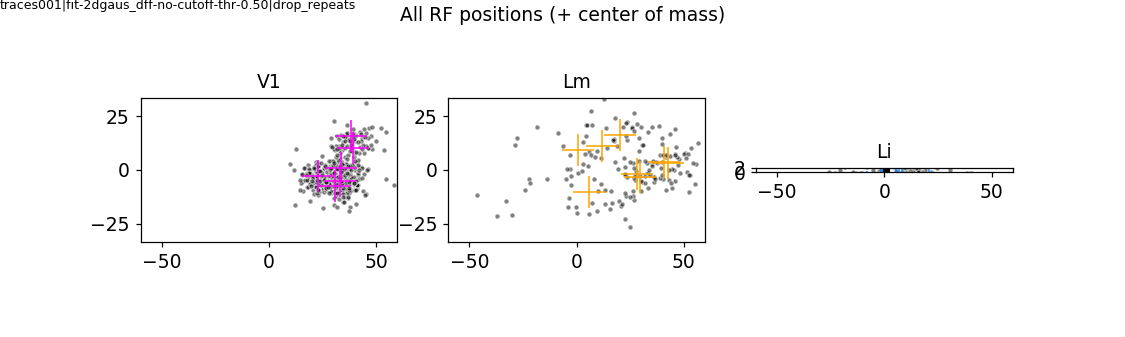

('/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/general-stats/drop_repeats', 'all_rfs_with_CoM_by-area__rfs10_R2-0.05')


In [432]:
fig, axn = pl.subplots(1,3, figsize=(10,3), dpi=dpi)
for (visual_area, animalid, session, fovnum), tmpd in df.groupby(['visual_area', 'animalid', 'session', 'fovnum']):
    ai = visual_areas.index(visual_area)
    ax = axn[ai]
    sns.scatterplot('x0', 'y0', data=tmpd, ax=ax, color='k', #area_colors[visual_area],
                   s=10, marker='o', alpha=0.5) #, edgecolor='k') #area_colors[visual_area])
    
    x = tmpd['x0'].values
    y=tmpd['y0'].values
    m=np.ones(tmpd['x0'].shape)
    cgx = np.sum(x*m)/np.sum(m)
    cgy = np.sum(y*m)/np.sum(m)
    #print('The center of mass: (%.2f, %.2f)' % (cgx, cgy))
    ax.plot(cgx, cgy, marker='+', markersize=20, 
            color=area_colors[visual_area], alpha=1) #c=rgba_colors, 
    n_cells.append(tmpd.shape[0])
    ax.set_title(visual_area)
    
for ax in axn:
    ax.set_xlim([screenleft, screenright])
    ax.set_ylim([screenbottom, screentop])
    ax.set_aspect('equal')
    ax.set_ylabel('')
    ax.set_xlabel('')
    
pl.suptitle("All RF positions (+ center of mass)")

label_figure(fig, data_id)
figname = 'all_rfs_with_CoM_by-area__%s_%s' % (rfname, thr_str)
pl.savefig(os.path.join(genstats_dir, '%s.svg' % figname))
print(genstats_dir, figname)

#### Label each fov

In [553]:
df.head()

r2     fwhm_x     fwhm_y     theta         x0         y0 animalid  \
22  0.585001  46.670332  36.780253  6.081151 -29.065480 -11.080597    JC089   
23  0.696801  45.149795  27.452993  0.127034  13.248381 -21.937449    JC089   
24  0.876773  28.931146  20.644447  6.106297  24.519398   2.811875    JC089   
25  0.529471  29.483275  25.960252  6.261067  12.547553   2.575407    JC089   
26  0.767423  31.775266  30.710669  0.442568   3.718242  11.808561    JC089   

    cell              datakey experiment   ...            fx        fy  \
22    71  20190522_JC089_fov1      rfs10   ...     19.455779  3.985095   
23    89  20190522_JC089_fov1      rfs10   ...     19.057864  2.434098   
24    99  20190522_JC089_fov1      rfs10   ...     12.119023  2.166355   
25   113  20190522_JC089_fov1      rfs10   ...     12.543006  0.277473   
26   116  20190522_JC089_fov1      rfs10   ...     12.218671  5.790689   

    ratio_xy   theta_c  fov_xpos  fov_xpos_pix  fov_ypos  fov_ypos_pix  \
22  1.268896 -0.202034   433.246           188   415.011           218   
23  1.644622  0.127034   668.305           290   489.256           257   
24  1.401401 -0.176888   695.959           302   603.479           317   
25  1.135708 -0.022118   615.302           267   711.991           374   
26  1.034665  0.442568   566.907           246   805.273           423   

     ml_pos   ap_pos  
22  557.789  744.354  
23  483.544  509.295  
24  369.321  481.641  
25  260.809  562.298  
26  167.527  610.693  

[5 rows x 29 columns]

<IPython.core.display.Javascript object>


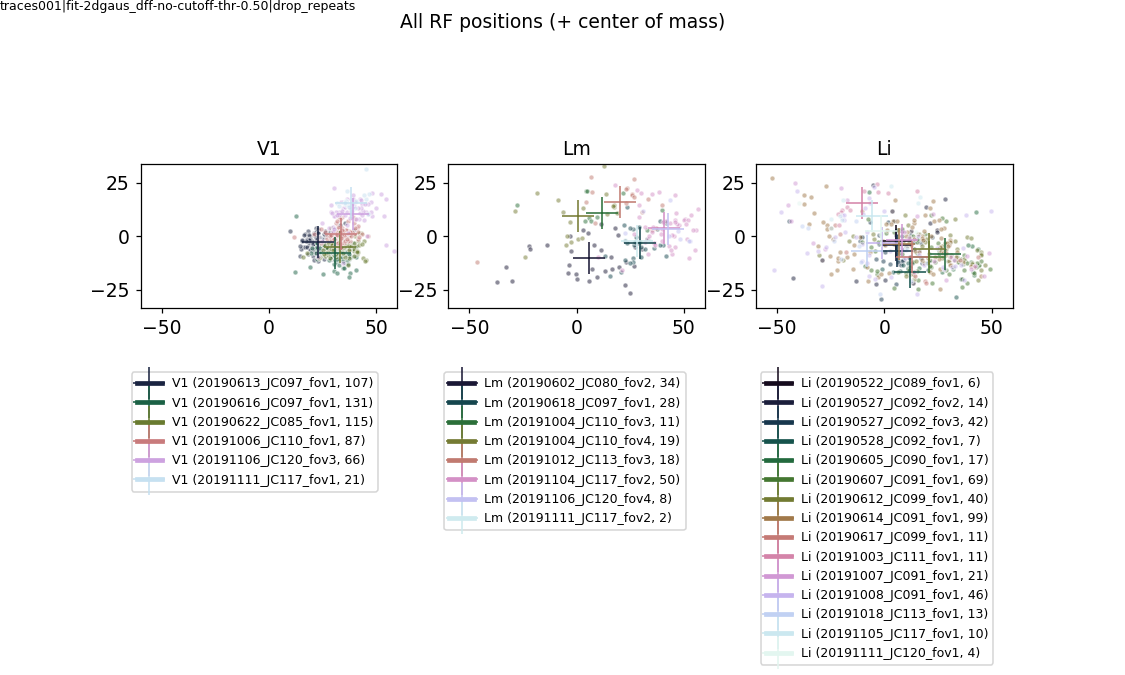

('/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/general-stats/drop_repeats', 'all_rfs_with_CoM_label-fovs__rfs10_R2-0.05')


In [560]:

fig, axn = pl.subplots(1,3, figsize=(10,6), dpi=dpi)
for visual_area, v_df in df.groupby(['visual_area']):
    ai = visual_areas.index(visual_area)
    ax = axn[ai]
    dcolors = sns.color_palette('cubehelix', n_colors=len(v_df['datakey'].unique()))
    for di, (datakey, d_df) in enumerate(v_df.groupby(['datakey'])):
        sns.scatterplot('x0', 'y0', data=d_df, ax=ax, color=dcolors[di],
                        #palette=dcolors, #area_colors[visual_area],
                       s=10, marker='o', alpha=0.5) #, edgecolor='k') #area_colors[visual_area])

        x = d_df['x0'].values
        y=d_df['y0'].values
        
        ncells_t = d_df.shape[0]
        m=np.ones(d_df['x0'].shape)
        cgx = np.sum(x*m)/np.sum(m)
        cgy = np.sum(y*m)/np.sum(m)
        #print('The center of mass: (%.2f, %.2f)' % (cgx, cgy))
        ax.plot(cgx, cgy, marker='+', markersize=20, color=dcolors[di], #area_colors[visual_area],
                label='%s (%s, %i)' % (visual_area, datakey, ncells_t), lw=3)
        
    ax.set_title(visual_area)
    ax.legend(bbox_to_anchor=(0.95, -0.4), fontsize=8) #1))

for ax in axn:
    ax.set_xlim([screenleft, screenright])
    ax.set_ylim([screenbottom, screentop])
    ax.set_aspect('equal')
    ax.set_ylabel('')
    ax.set_xlabel('')
    
pl.suptitle("All RF positions (+ center of mass)")
pl.subplots_adjust(top=0.9, bottom=0.4)


label_figure(fig, data_id)
figname = 'all_rfs_with_CoM_label-fovs__%s_%s' % (rfname, thr_str)
pl.savefig(os.path.join(genstats_dir, '%s.svg' % figname))
print(genstats_dir, figname)

# Calculate RF overlaps

In [414]:
from pipeline.python.classifications import rf_utils as rfutils

In [205]:

# from matplotlib.patches import Ellipse, Rectangle, Polygon
# from shapely.geometry.point import Point
# from shapely.geometry import box
# from shapely import affinity
# from shapely.ops import cascaded_union

# def create_ellipse(center, lengths, angle=0):
#     """
#     create a shapely ellipse. adapted from
#     https://gis.stackexchange.com/a/243462
#     """
#     circ = Point(center).buffer(1)
#     ell = affinity.scale(circ, int(lengths[0]), int(lengths[1]))
#     ellr = affinity.rotate(ell, angle)
#     return ellr

# def rfs_to_polys(rffits, sigma_scale=2.35):
#     '''
#     rffits (pd dataframe)
#         index : roi indices (same as gdf.rois)
#         columns : r2, sigma_x, sigma_y, theta, x0, y0 (already converted) 
    
#     returns list of polygons to do calculations with
#     '''
#     rf_polys=[]
#     for roi in rffits['cell']: #.index.tolist():
#         _, sx, sy, th, x0, y0 = rffits.loc[roi]
#         s_ell = create_ellipse((x0, y0), (abs(sx)*sigma_scale, abs(sy)*sigma_scale), np.rad2deg(th))
#         rf_polys.append((roi, s_ell))
#     return rf_polys

# def stimsize_poly(sz, xpos=0, ypos=0):
    
#     ry_min = ypos - sz/2.
#     rx_min = xpos - sz/2.
#     ry_max = ypos + sz/2.
#     rx_max = xpos + sz/2.
#     s_blobs = box(rx_min, ry_min, rx_max, ry_max)
    
#     return s_blobs


def get_stim_info(animalid, session, fov):

    stiminfo = rfutils.get_screen_info(animalid, session, fov)
    screen_bounds = [stiminfo['linminH'], stiminfo['linminW'], stiminfo['linmaxH'], stiminfo['linmaxW']]
    screen_aspect = stiminfo['resolution'][0] / float(stiminfo['resolution'][1])

    screen_width_deg = stiminfo['linmaxW']*2.
    screen_height_deg = stiminfo['linmaxH']*2.

    pix_per_degW = stiminfo['resolution'][0] / screen_width_deg
    pix_per_degH = stiminfo['resolution'][1] / screen_height_deg 

    #print(pix_per_degW, pix_per_degH)
    pix_per_deg = np.mean([pix_per_degW, pix_per_degH])
    print("avg pix/deg: %.2f" % pix_per_deg)
    
    stiminfo = {'stimulus_sizes': sorted(sdf['size'].unique()),
                'screen_bounds': screen_bounds,
                'screen_aspect': screen_aspect,
                'pix_per_deg': pix_per_deg,
                'stimulus_xpos': stiminfo['stim_pos'][0],
                'stimulus_ypos': stiminfo['stim_pos'][1]}
    return stiminfo


# def get_overlaps(rfstats, stiminfo, roi_list=None):
#     if roi_list is None:
#         roi_list = rfstats.keys()
    
#     #stiminfo = get_stim_info(animalid, session, fov)
#     rffits = fitrf.rfits_to_df(rfstats['fit_results'], 
#                                 row_vals=rfstats['row_vals'],
#                                 col_vals=rfstats['col_vals'],
#                                 roi_list=sorted(roi_list))
    
#     rf_polys = rfs_to_polys(rffits)

#     # Create shapes for each stim size (bounding box)
#     stim_polys = [stimsize_poly(blob_sz, xpos=stiminfo['stimulus_xpos'], ypos=stiminfo['stimulus_ypos'])\
#                   for blob_sz in stiminfo['stimulus_sizes']]
#     stim_labels = ['%i' % blob_sz for blob_sz in stiminfo['stimulus_sizes']]

#     ## Caculate overlaps and put into dataframe
#     overlaps=[]
#     for s_label, s_poly in zip(stim_labels, stim_polys):
#         tdf = pd.DataFrame({'overlap': [(s_ell.intersection(s_poly)).area / s_ell.area \
#                                    for s_ell in rf_polys],
#                             #'distance': rf_dist_from_center,
#                             'size': [s_label for _ in range(len(rf_polys))],
#                             'rid': roi_list})
#         overlaps.append(tdf)

#     overlaps = pd.concat(overlaps, axis=0)
    
#     return overlaps


In [416]:
reload(rfutils)

<module 'pipeline.python.classifications.rf_utils' from '/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/rf_utils.py'>

In [417]:
# def get_proportion_overlap(poly_tuple1, poly_tuple2):
#     r1, poly1 = poly_tuple1
#     r2, poly2 = poly_tuple2

#     area_of_smaller = min([poly1.area, poly2.area])
#     overlap_area = poly1.intersection(poly2).area
#     perc_overlap = overlap_area/area_of_smaller
#     #print(perc_overlap, overlap_area, area_of_smaller)
#     odf = pd.DataFrame({'row':r1,
#                         'col': r2,
#                         'area_overlap': overlap_area,
#                         'perc_overlap': perc_overlap}, index=[0])
    
#     return odf

In [418]:
#### Test with a few pairs
g = df[df['datakey']==datakey].copy()

# convert RF fit params to polygon
g.index = g['cell'].values
rf_fit_params = ['cell', 'std_x', 'std_y', 'theta', 'x0', 'y0']

rf_polys = rfutils.rfs_to_polys(g[rf_fit_params])


# Test 1 pair
rid1=57
rid2=78
p1 = [i for i, v in enumerate(rf_polys) if v[0]==rid1][0]
p2 = [i for i, v in enumerate(rf_polys) if v[0]==rid2][0]

poly1 = rf_polys[p1][1]
poly2 = rf_polys[p2][1]
print(poly1.area, poly2.area)

perc_overlap = rfutils.get_proportion_overlap(rf_polys[p1], rf_polys[p2])

fig, ax =pl.subplots()
x, y = poly1.exterior.xy
ax.plot(x, y)
ax.set_title(perc_overlap)
x, y = poly2.exterior.xy
ax.plot(x, y)


IndexError: list index out of range

In [346]:
print("Poly centroids:", list(poly1.centroid.coords))
print("Estimated RF center:", g[g['cell']==rid1][['x0', 'y0']].values)


('Poly centroids:', [(48.31425181975433, 9.56227911360078)])
('Estimated RF center:', array([[ 48.31425182,   9.56227911]]))


In [420]:
reload(rfutils)

<module 'pipeline.python.classifications.rf_utils' from '/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/rf_utils.py'>

# Calculate % RF overlap for all pairs of cells

In [433]:
o_list=[]
for (visual_area, animalid, session, fovnum, datakey), g in df.groupby(['visual_area', 'animalid', 'session', 'fovnum', 'datakey']):

    # convert RF fit params to polygon
    g.index = g['cell'].values
    rf_polys = rfutils.rfs_to_polys(g[rf_fit_params])

    # Get all pairwise overlaps (% of smaller ellipse that overlaps larger ellipse)
    pair_ixs = list(itertools.combinations(np.arange(0, len(rf_polys)), 2))
    overlaps = pd.concat([rfutils.get_proportion_overlap(rf_polys[p1], rf_polys[p2]) for (p1, p2) in pair_ixs], axis=0)
    metadict={'visual_area': visual_area, 'animalid': animalid, 
              'session': session, 'fovnum': fovnum, 'datakey': datakey}
    o_ = putils.add_meta_to_df(overlaps, metadict)
    o_list.append(o_)

overlaps = pd.concat(o_list, axis=0).reset_index(drop=True)

In [440]:
mean_overlaps = overlaps.groupby(['visual_area', 'datakey']).mean().reset_index()
mean_overlaps['animalid'] = [s.split('_')[1] for s in mean_overlaps['datakey']]
mean_overlaps['session'] = [s.split('_')[0] for s in mean_overlaps['datakey']]
#mean_overlaps['session'] = [s.split('_')[0] for s in mean_overlaps['datakey']]


<IPython.core.display.Javascript object>


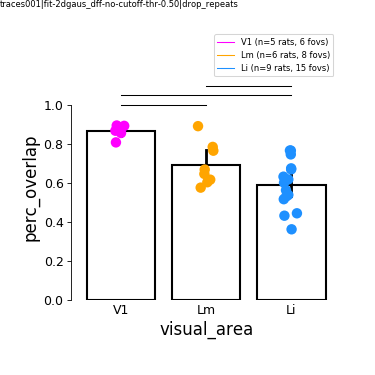

********* perc_overlap **********
[('V1', 'Lm')] p=0.012 (holm), reject H0=True
[('V1', 'Li')] p=0.001 (holm), reject H0=True
[('Lm', 'Li')] p=0.050 (holm), reject H0=True
****************************
('/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/general-stats/drop_repeats', 'perc_overlap_avg-fovs_rfs10_multicomp-holm___drop_repeats')


In [498]:
curr_metric = 'perc_overlap'

fg = sns.catplot(x="visual_area", y=curr_metric, data=mean_overlaps, #hue="experiment", 
               kind = 'bar',
                errcolor="k", edgecolor=('k', 'k', 'k'), order=visual_areas,
                facecolor=(1,1,1,0), linewidth=2, zorder=0, legend=0) #, ax=ax)
sns.stripplot(x='visual_area', y=curr_metric, data=mean_overlaps, #hue='experiment',
             order=visual_areas, ax=fg.ax, palette=area_colors, dodge=True,
             size=10)
fg.ax.tick_params(axis='x', size=0)
fg.ax.set_ylabel(curr_metric)

pl.subplots_adjust(top=0.8, bottom=0.2, left=0.2, right=0.9)
#fg.ax.tick_params(axis='x', size=0)

print("********* %s **********" % (curr_metric))
statresults = aggr.do_mannwhitney(mean_overlaps, metric=curr_metric, multi_comp_test=multi_comp_test)
aggr.annotate_stats_areas(statresults, fg.ax, lw=1, color='k', 
                         visual_areas=['V1', 'Lm', 'Li'], y_loc=1, offset=0.05)
print("****************************")
#ax.set_ylim([0, 2.])

# Get counts of samples for legend
legend_elements = aggr.get_counts_for_legend(mean_overlaps, area_colors=area_colors, markersize=10, marker='_')
fg.ax.legend(handles=legend_elements, bbox_to_anchor=(1,1.2), fontsize=8)

sns.despine(offset=4, trim=True, bottom=True, ax=fg.ax)


label_figure(fg.fig, data_id)

figname = '%s_avg-fovs_%s_multicomp-%s___%s' % (curr_metric, rfname, multi_comp_test, filter_by)
fg.fig.savefig(os.path.join(genstats_dir, '%s.svg' % figname))
print(genstats_dir, figname)


## RF overlap vs. Euclidean distance bw neuron pairs

In [ ]:
# import scipy.spatial as spatial
# from pipeline.python.rois.utils import load_roi_coords

In [ ]:
# r_list = []
# for (visual_area, animalid, session, fovnum), g in sdata_exp.groupby(['visual_area', 'animalid', 'session', 'fovnum']):
#     datakey = '_'.join([session, animalid, 'fov%i' % fovnum])
#     fcoords = load_roi_coords(animalid, session, 'FOV%i_zoom2p0x' % fovnum, 
#                               traceid=traceid, create_new=False)
#     cc = fcoords['roi_positions'].copy()
#     metadict={'visual_area': visual_area, 'animalid': animalid, 
#           'session': session, 'fovnum': fovnum, 'datakey': datakey}
#     cc = putils.add_meta_to_df(cc, metadict)
#     r_list.append(cc)
# roi_positions = pd.concat(r_list, axis=0)

In [426]:
overlaps.head()

area_overlap  col  perc_overlap  row   session              datakey  \
0   1731.762216   89      0.454423   71  20190522  20190522_JC089_fov1   
1    321.846098   99      0.183235   71  20190522  20190522_JC089_fov1   
2    930.561257  113      0.409218   71  20190522  20190522_JC089_fov1   
3   1246.917699  116      0.427467   71  20190522  20190522_JC089_fov1   
4   1467.093096  145      0.492359   71  20190522  20190522_JC089_fov1   

  visual_area  fovnum animalid  
0          Li       1    JC089  
1          Li       1    JC089  
2          Li       1    JC089  
3          Li       1    JC089  
4          Li       1    JC089

In [462]:
datakeys = overlaps['datakey'].unique()
overlaps['distance'] = ''

for di, (datakey, currdf) in enumerate(overlaps.groupby(['datakey'])):
    if di%5==0:
        print('%i of %i dsets' % (int(di+1), len(datakeys)))
        
    tmpdf = df[df['datakey']==datakey].copy()
    tmpdf.index=tmpdf['cell'].values
    
    # Coords of cell1 in pair, in order
    coords1 = np.array(tmpdf.loc[currdf['row'].values][['ml_pos', 'ap_pos']])
    # Coords of cell2 in pair 
    coords2 = np.array(tmpdf.loc[currdf['col'].values][['ml_pos', 'ap_pos']])

    # Get dists, in order of appearance
    dists = [np.linalg.norm(c1-c2) for c1, c2 in zip(coords1, coords2)]
    
    overlaps['distance'][currdf.index] = dists #d_df['distance'].values


1 of 29 dsets
6 of 29 dsets
11 of 29 dsets
16 of 29 dsets
21 of 29 dsets
26 of 29 dsets


In [551]:
n_bins = 10
use_quartile=False

bin_type = 'eqpop%i' % n_bins if use_quartile else 'eqwidth%i' % n_bins
print("binning: %s" % bin_type)

if use_quartile:
    overlaps['binned_dist'] = pd.qcut(overlaps['distance'], n_bins, labels=False)
else:
    overlaps['binned_dist'] = pd.cut(overlaps['distance'], n_bins, labels=False)
#_, bin_sizes = pd.qcut(tuning_corrcoefs['distance'], n_bins, retbins=True)
#bin_edges = bin_sizes[0:-1]
params = ['perc_overlap', 'area_overlap', 'distance', 'binned_dist']
for p in params:
    overlaps[p] = overlaps[p].astype(float)
    

binning: eqwidth10


<IPython.core.display.Javascript object>


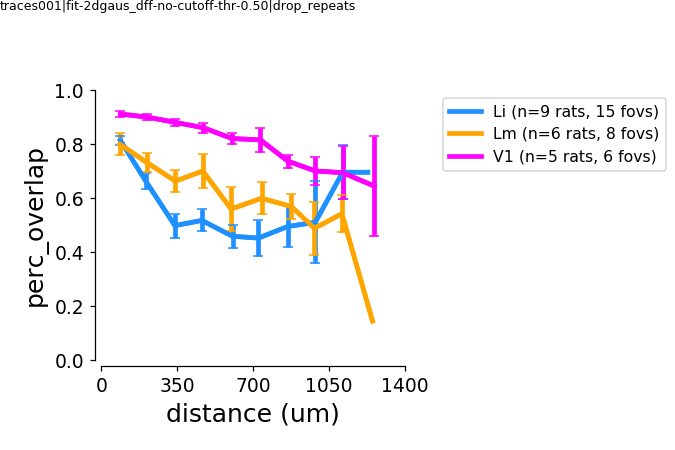

('/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/general-stats/drop_repeats', 'perc_overlap_by_distance_eqwidth10_avg-fovs_rfs10_multicomp-holm___drop_repeats')


In [552]:
use_std = False
max_x = 1000 if use_quartile else 1400
#max_x = int(overlaps['distance'].max())
fig, ax = pl.subplots(figsize=(6,4), sharex=True, sharey=True, dpi=dpi)
curr_metric = 'perc_overlap'
fig_title = 'Frac. overlap'
for visual_area, currdf in overlaps.groupby(['visual_area']):
    n_rats = len(currdf['animalid'].unique())
    n_fovs = len(currdf['datakey'].unique())

    bin_dists = [b_df.groupby(['datakey'])['distance'].mean().mean() for b, b_df in currdf.groupby(['binned_dist'])]
    bin_ccs = [b_df.groupby(['datakey'])[curr_metric].mean().mean() for b, b_df in currdf.groupby(['binned_dist'])]
    bin_sems = [spstats.sem(b_df.groupby(['datakey'])[curr_metric].mean()) for b, b_df in currdf.groupby(['binned_dist'])]
    bin_stds = [b_df.groupby(['datakey'])[curr_metric].mean().std() for b, b_df in currdf.groupby(['binned_dist'])]
    bin_errs = bin_stds if use_std else bin_sems
    
    ax.plot(bin_dists, bin_ccs, color=area_colors[visual_area], 
           label='%s (n=%i rats, %i fovs)' % (visual_area, n_rats, n_fovs), lw=3)
    ax.errorbar(bin_dists, bin_ccs, yerr=bin_errs, color=area_colors[visual_area], lw=3, capsize=3)
ax.legend(bbox_to_anchor=(1.1, 1), fontsize=10)
ax.set_ylabel(curr_metric)
ax.set_xlabel('distance (um)')
#ax.set_title(fig_title, fontsize=16)
ax.set_ylim([0, 1])
ax.set_xlim([0, max_x])
ax.set_xticks(np.linspace(0, max_x, 5))

sns.despine(trim=True, offset=4)

label_figure(fig, data_id)
pl.subplots_adjust(right=0.6, top=0.8, left=0.15, bottom=0.2)
figname = '%s_by_distance_%s_avg-fovs_%s_multicomp-%s___%s' % (curr_metric, bin_type, rfname, multi_comp_test, filter_by)
fig.savefig(os.path.join(genstats_dir, '%s.svg' % figname))
print(genstats_dir, figname)


In [545]:
max_x

1000

In [389]:
#### Output dir
stats_dir = os.path.join(aggregate_dir, 'data-stats')

In [395]:
# Get blob metadata only - and only if have RFs
sdata_exp = pd.concat([g for k, g in sdata.groupby(['animalid', 'session', 'fov']) if 
                        (experiment in g['experiment'].values 
                         and ('rfs' in g['experiment'].values or 'rfs10' in g['experiment'].values))])

sdata_exp[['visual_area', 'animalid', 'session', 'fov']].drop_duplicates().groupby(['visual_area']).count()

animalid  session  fov
visual_area                        
Li                 13       13   13
Lm                 12       12   12
V1                 11       11   11

In [396]:
experiment = 'blobs'
has_gratings=False
filterby_stimulus = 'first'

# Drop duplicates and whatnot fovs
if experiment=='blobs':
    exp_dkeys = aggr.get_blob_datasets(filter_by=filterby_stimulus, has_gratings=has_gratings, as_dict=True)
elif experiment == 'gratings':
    exp_dkeys = aggr.get_gratings_datasets(filter_by=filter_by, as_dict=True)

for k, v in exp_dkeys.items():
    print('%s: %i datasets' % (k, len(v)))

dictkeys = [d for d in list(itertools.chain(*exp_dkeys.values()))]
full_datakeys = ['%s_%s_fov%i' % (s.split('_')[0], s.split('_')[1], 
                   sdata[(sdata['animalid']==s.split('_')[1]) & (sdata['session']==s.split('_')[0])]['fovnum'].unique()[0]) for s in dictkeys]
expmeta = dict((k, [dv for dv in full_datakeys for vv in v if vv in dv]) for k, v in exp_dkeys.items())

V1: 8 datasets
Lm: 8 datasets
Li: 9 datasets


In [397]:
sdata_exp['datakey'] = ['%s_%s_fov%i' % (session, animalid, fovnum) 
                              for session, animalid, fovnum in zip(sdata_exp['session'].values, 
                                                                   sdata_exp['animalid'].values,
                                                                   sdata_exp['fovnum'].values)]

In [398]:
sdata_exp

animalid experiment            fov   session visual_area  fovnum  \
122    JC076      blobs  FOV1_zoom2p0x  20190420          V1       1   
123    JC076     retino  FOV1_zoom2p0x  20190420          V1       1   
124    JC076        rfs  FOV1_zoom2p0x  20190420          V1       1   
125    JC076      blobs  FOV1_zoom2p0x  20190501          V1       1   
126    JC076     retino  FOV1_zoom2p0x  20190501          V1       1   
127    JC076        rfs  FOV1_zoom2p0x  20190501          V1       1   
130    JC076      blobs  FOV1_zoom2p0x  20190502          Li       1   
131    JC076        rfs  FOV1_zoom2p0x  20190502          Li       1   
137    JC078      blobs  FOV1_zoom2p0x  20190430          Lm       1   
138    JC078     retino  FOV1_zoom2p0x  20190430          Lm       1   
139    JC078        rfs  FOV1_zoom2p0x  20190430          Lm       1   
134    JC078      blobs  FOV1_zoom2p0x  20190504          Lm       1   
135    JC078     retino  FOV1_zoom2p0x  20190504          Lm       1   
136    JC078        rfs  FOV1_zoom2p0x  20190504          Lm       1   
140    JC078      blobs  FOV1_zoom2p0x  20190509          Lm       1   
141    JC078     retino  FOV1_zoom2p0x  20190509          Lm       1   
142    JC078        rfs  FOV1_zoom2p0x  20190509          Lm       1   
143    JC078        rfs  FOV1_zoom2p0x  20190513          Lm       1   
144    JC078   gratings  FOV1_zoom2p0x  20190513          Lm       1   
145    JC078      blobs  FOV1_zoom2p0x  20190513          Lm       1   
146    JC078     retino  FOV1_zoom2p0x  20190513          Lm       1   
151    JC080      blobs  FOV1_zoom2p0x  20190506          Lm       1   
152    JC080     retino  FOV1_zoom2p0x  20190506          Lm       1   
153    JC080        rfs  FOV1_zoom2p0x  20190506          Lm       1   
147    JC080        rfs  FOV1_zoom2p0x  20190603          Lm       1   
148    JC080   gratings  FOV1_zoom2p0x  20190603          Lm       1   
149    JC080      blobs  FOV1_zoom2p0x  20190603          Lm       1   
150    JC080     retino  FOV1_zoom2p0x  20190603          Lm       1   
161    JC083      blobs  FOV1_zoom2p0x  20190507          V1       1   
162    JC083     retino  FOV1_zoom2p0x  20190507          V1       1   
..       ...        ...            ...       ...         ...     ...   
90     JC097     retino  FOV1_zoom2p0x  20190618          Lm       1   
64     JC099      rfs10  FOV1_zoom2p0x  20190609          Li       1   
65     JC099   gratings  FOV1_zoom2p0x  20190609          Li       1   
66     JC099      blobs  FOV1_zoom2p0x  20190609          Li       1   
67     JC099     retino  FOV1_zoom2p0x  20190609          Li       1   
56     JC099      rfs10  FOV1_zoom2p0x  20190612          Li       1   
57     JC099   gratings  FOV1_zoom2p0x  20190612          Li       1   
58     JC099      blobs  FOV1_zoom2p0x  20190612          Li       1   
59     JC099     retino  FOV1_zoom2p0x  20190612          Li       1   
60     JC099      rfs10  FOV1_zoom2p0x  20190617          Li       1   
61     JC099   gratings  FOV1_zoom2p0x  20190617          Li       1   
62     JC099      blobs  FOV1_zoom2p0x  20190617          Li       1   
63     JC099     retino  FOV1_zoom2p0x  20190617          Li       1   
91     JC110        rfs  FOV1_zoom2p0x  20191006          V1       1   
92     JC110      rfs10  FOV1_zoom2p0x  20191006          V1       1   
93     JC110   gratings  FOV1_zoom2p0x  20191006          V1       1   
94     JC110      blobs  FOV1_zoom2p0x  20191006          V1       1   
95     JC110     retino  FOV1_zoom2p0x  20191006          V1       1   
192    JC113      rfs10  FOV1_zoom2p0x  20191018          Li       1   
193    JC113   gratings  FOV1_zoom2p0x  20191018          Li       1   
194    JC113      blobs  FOV1_zoom2p0x  20191018          Li       1   
195    JC113     retino  FOV1_zoom2p0x  20191018          Li       1   
110    JC117      rfs10  FOV1_zoom2p0x  20191105          Li       1   
111    JC117   gratings  FOV1_zoom2p0x  2019

In [ ]:
glob.glob(os.path.join(stats_dir, 'aggr_%s_trialmeans_*%s*_%s_stimulus.pkl' % (experiment, responsive_test, response_type)))


In [ ]:
#aggr_trialmeans_dfile = glob.glob(os.path.join(stats_dir, 'aggr_blobs_*%s*.pkl' % responsive_test))[0]
aggr_trialmeans_dfile = glob.glob(os.path.join(stats_dir, 
                                'aggr_%s_trialmeans_*%s*_%s_stimulus.pkl' 
                                               % (experiment, responsive_test, response_type)))[0]

print(aggr_trialmeans_dfile)
with open(aggr_trialmeans_dfile, 'rb') as f:
    MEANS = pkl.load(f)
    

In [ ]:
animalid = 'JC084'
session = '20190522'
fovnum = 1
datakey = '%s_%s_fov%i' % (session, animalid, fovnum)

if experiment == 'blobs':
    obj = util.Objects(animalid, session, 'FOV%i_zoom2p0x' %  fovnum, traceid=traceid)
else:
    obj = util.Gratings(animalid, session, 'FOV%i_zoom2p0x' %  fovnum, traceid=traceid)
sdf = obj.get_stimuli()

curr_datakeys = [k for k in full_datakeys if k not in excl]
curr_sdata = sdata_exp[sdata_exp['datakey'].isin(curr_datakeys)].copy()
print(len(curr_datakeys), len(full_datakeys))

In [ ]:
include_stimuli='images'

all_configs = ['config%03d' % i for i in np.arange(1, sdf.shape[0]+1)]
if experiment=='blobs':
    control_configs = ['config001', 'config002', 'config003', 'config004', 'config005']
elif experiment=='gratings':
    control_configs = sdf[sdf['size']>100].index.tolist()
    
if include_stimuli=='fullscreen':
    included_configs = [c for c in all_configs if c in control_configs]
elif include_stimuli=='image':
    included_configs = [c for c in all_configs if c not in control_configs]
elif include_stimuli=='all':
    included_configs = all_configs
else:
    print("UNKNOWN: %s" % include_stimuli)
print("Restricting stimuli to: %s (%i conditions)" % (include_stimuli, len(included_configs)))

In [ ]:
x_list = []
for (visual_area, animalid, session, fovnum), g in curr_sdata.groupby(['visual_area', 'animalid', 'session', 'fovnum']):

    datakey = '_'.join([session, animalid, 'fov%i' % fovnum])
    if datakey not in MEANS.keys():
        print('... missing %s' % datakey)
        continue
    trial_means = MEANS[datakey].copy() # shape: (ntrials_total, nrois_total)
    if response_type == 'corrected':
        cfg_tmp = trial_means['config']
        trial_means = putils.zscore_dataframe(trial_means)
        trial_means['config'] = cfg_tmp
        
    tuning_ = trial_means[trial_means['config'].isin(included_configs)].groupby(['config']).mean().reset_index()
    cc = melt_square_matrix(tuning_.corr(), metric_name='corrcoef', include_diagonal=False)
    
    metadict={'visual_area': visual_area, 'animalid': animalid, 
              'session': session, 'fovnum': fovnum, 'datakey': datakey}
    cc = add_metadata(cc, metadict)
    x_list.append(cc)

signal_corrs = pd.concat(x_list, axis=0).reset_index(drop=True)

# Get mean across animals
mean_signal_corrs = signal_corrs.groupby(['visual_area', 'datakey']).mean().reset_index()

<IPython.core.display.Javascript object>


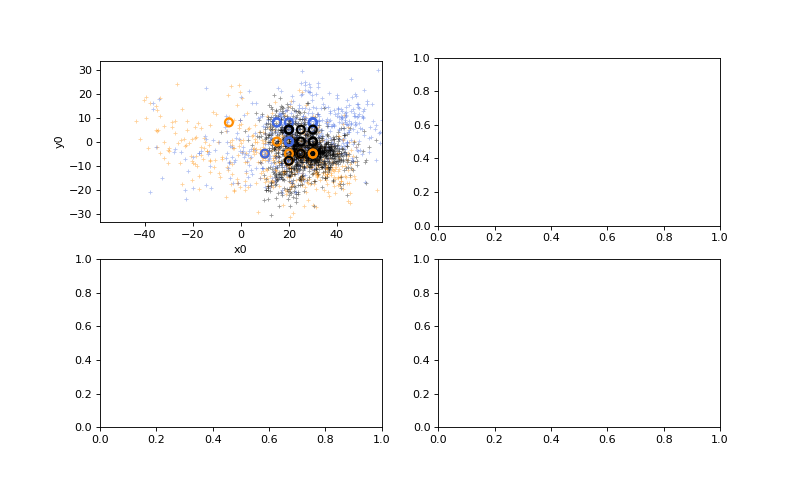

In [303]:
n_cells = []

fig, axes = pl.subplots(2, 2, figsize=(10,6))
ax = axes[0,0]
for (visual_area, animalid, session, fov), tmpd in expdf.groupby(['visual_area', 'animalid', 'session', 'fov']):
    sns.scatterplot('x0', 'y0', data=tmpd, ax=ax, color=area_colors[visual_area],
                   s=10, marker='+', alpha=0.4, edgecolor=area_colors[visual_area])
    ax.set_xlim([screenleft, screenright])
    ax.set_ylim([screenbottom, screentop])
    ax.set_aspect(screenaspect)

    n_cells.append(tmpd.shape[0])

ax = axes[0,0]
for visual_area, tmpd in rfdf.groupby(['visual_area']):
    xcoms = [float(g['CoM-x'].unique()) for k, g in tmpd.groupby(['animalid', 'session', 'fov'])]
    ycoms = [float(g['CoM-y'].unique()) for k, g in tmpd.groupby(['animalid', 'session', 'fov'])]
    ncells = np.array([g.shape[0] for k, g in tmpd.groupby(['animalid', 'session', 'fov'])])
    cell_alphas = [convert_range(float(n), newmin=0, newmax=1, oldmin=0, oldmax=max_ncells) for n in ncells]

    rgba_colors = [mplc.to_rgba(area_colors[visual_area], alpha=c/4.) for c in cell_alphas]
    
    ax.scatter(xcoms, ycoms, s=50, lw=2, edgecolors=area_colors[visual_area], alpha=1, facecolor='none') #c=rgba_colors, 
    #ax.scatter(xcoms, ycoms, s=ncells, c=rgba_colors)

    ax.set_xlim([screenleft, screenright])
    ax.set_ylim([screenbottom, screentop])
    ax.set_aspect(screenaspect)


In [232]:
ncells

[48, 17, 66, 38, 48, 111, 195, 181, 143, 124, 221, 85]